In [2]:
#import sys
#!{sys.executable} -m pip install countryinfo

In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from countryinfo import CountryInfo
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
import dill

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')

# Load data
data = pd.read_csv('covid_data.csv')

In [4]:
# Function to build model for given location
def get_mod(loc):
    
    try:
        
        # Subset the data
        locdata = data.loc[data['Country/Region'] == loc][['ds', 'Deaths']].rename({'Deaths': 'y'}, axis = 1).groupby('ds').sum().reset_index()
    
        # Build model
        mod = Prophet()
        mod.fit(locdata)
    
        # Predict
        fut = mod.make_future_dataframe(periods = 90)
        pred = mod.predict(fut)
    
        # Fix negatives
        pred['yhat'] = pred['yhat'].apply(lambda x: 0 if x < 0 else x)
        
        return pred
    
    except:
        
        print('SNAFU!!!')

# Function build growth model for given location
def get_log_mod(loc):

    try:
        
        # Subset the data
        locdata = data.loc[data['Country/Region'] == loc][['ds', 'Deaths']].rename({'Deaths': 'y'}, axis = 1).groupby('ds').sum().reset_index()
    
        # Set params
        locdata['floor'] = 0
        locdata['cap'] = [cn_[loc]['population']] * len(locdata)
    
        # Build log model
        mod = Prophet(growth = 'logistic')
    
        # Train
        mod.fit(locdata)
    
        # Predict
        fut = mod.make_future_dataframe(periods = 90)
        fut['floor'] = 0
        fut['cap'] = [cn_[loc]['population']] * len(fut)
    
        pred = mod.predict(fut)
    
        # Fix negatives
        pred['yhat'] = pred['yhat'].apply(lambda x: 0 if x < 0 else x)
    
        return pred
    
    except:
        
        print('SNAFU!!!')

In [5]:
data.shape

(39347, 8)

In [6]:
data.dtypes

SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object

In [7]:
# Fix country name listings
data['Country/Region'] = data['Country/Region'].apply(lambda x: x.strip())

# Inspect available countries
data['Country/Region'].unique()

array(['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea', 'Singapore', 'Philippines', 'Malaysia',
       'Vietnam', 'Australia', 'Mexico', 'Brazil', 'Colombia', 'France',
       'Nepal', 'Canada', 'Cambodia', 'Sri Lanka', 'Ivory Coast',
       'Germany', 'Finland', 'United Arab Emirates', 'India', 'Italy',
       'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt',
       'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan',
       'Bahrain', 'Kuwait', 'Austria', 'Algeria', 'Croatia',
       'Switzerland', 'Pakistan', 'Georgia', 'Greece', 'North Macedonia',
       'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands',
       'San Marino', 'Azerbaijan', 'Belarus', 'Iceland', 'Lithuania',
       'New Zealand', 'Nigeria', 'North Ireland', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Czech Republic', 'Armenia',
       'Dominican Republic', 'Indonesia', 'Portugal', 'Andorra', 'Latvia',
       'Morocco', '

In [8]:
# Convert dates
data['ObservationDate'] = pd.to_datetime(data['ObservationDate'])
data.rename({'ObservationDate': 'ds'}, axis = 1, inplace = True)

print('The dataset begins on {} and ends on {}..'.format(min(data['ds']), max(data['ds']))) 

The dataset begins on 2020-01-22 00:00:00 and ends on 2020-06-10 00:00:00..


In [9]:
# Calculate global effects
#global_d = data.groupby('ds').agg({'Deaths': 'sum',
#                                   'Confirmed': 'sum',
#                                   'Recovered': 'sum'})

# Visualize
#fig, ax = plt.subplots(figsize = [20, 10])
#ax.plot(global_d['Confirmed'], label = 'Cases')
#ax.plot(global_d['Deaths'], label = 'Deaths')
#ax.plot(global_d['Recovered'], label = 'Recoveries')
#ax.set_title('Aggregate Global Effects of COVID')
#ax.set_xlabel('Date')
#ax.legend()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


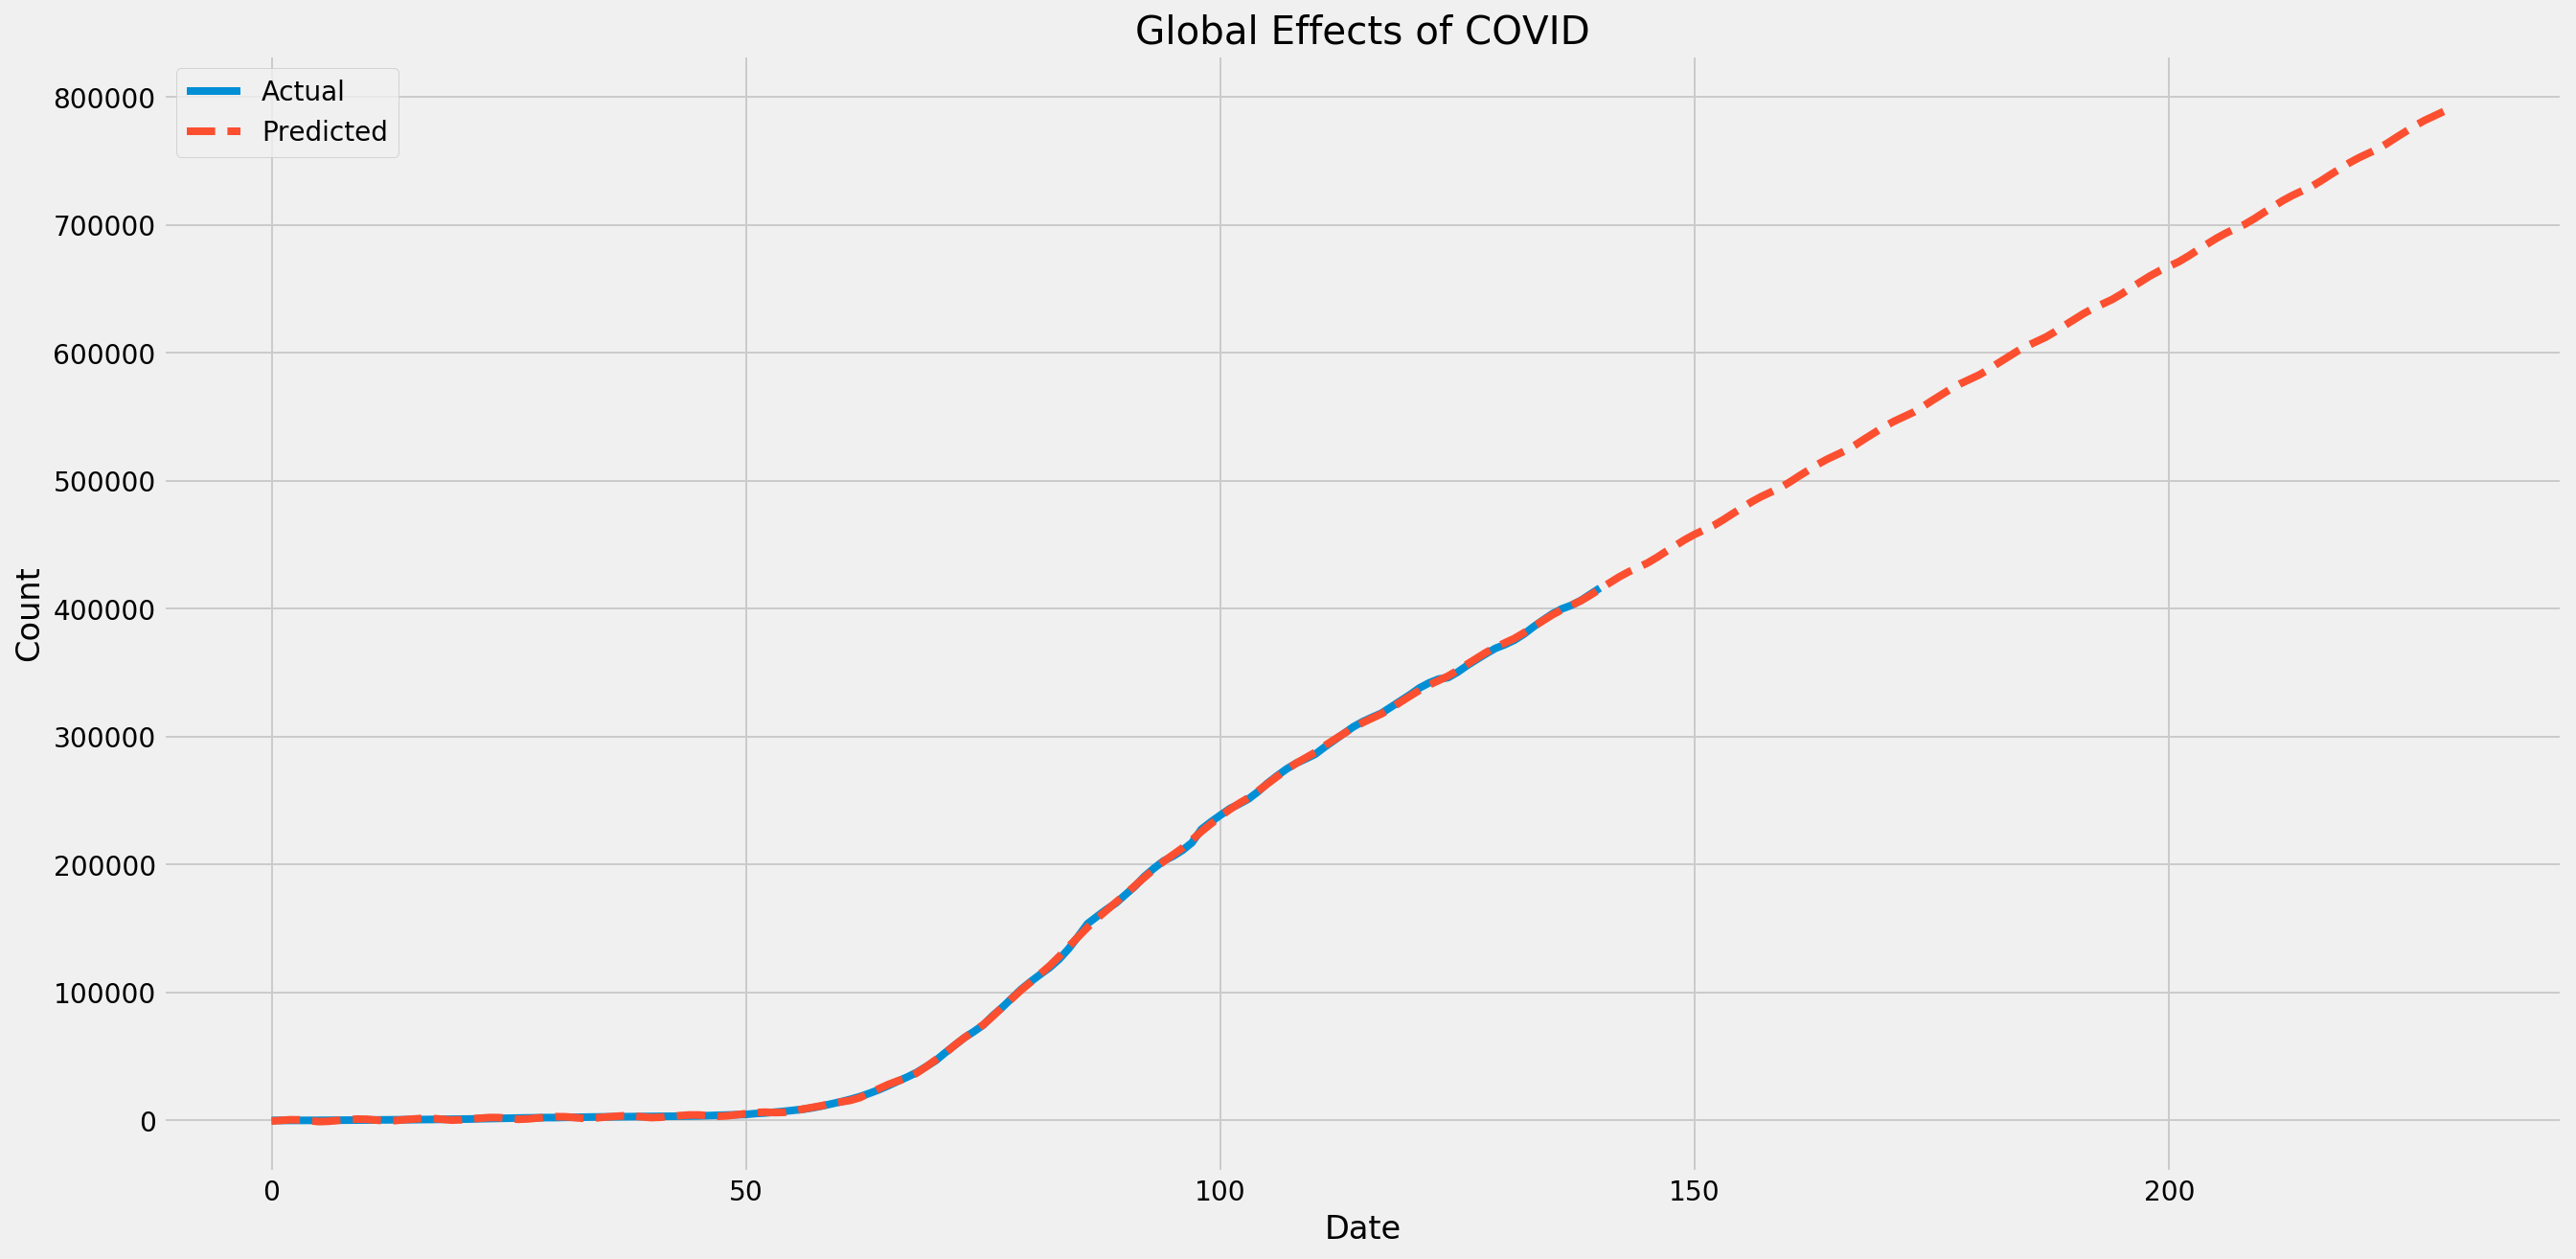

In [10]:
# Transform the data for mkodeling
fcst_data = data.groupby('ds')[['Deaths']].sum().reset_index().rename({'Deaths': 'y'}, axis = 1)

# Initialize
m = Prophet()
m.fit(fcst_data)

# Predict
fut = m.make_future_dataframe(periods = 90)
preds = m.predict(fut)

# Visualize
fig, ax = plt.subplots(figsize = [20, 10])
ax.plot(fcst_data['y'], label = 'Actual')
ax.plot(preds['yhat'], label = 'Predicted', linestyle = '--')
ax.legend()
ax.set_title('Global Effects of COVID')
ax.set_xlabel('Date')
ax.set_ylabel('Count');

In [11]:
# Get location info for reach country
cn_ = {}

# Iterate available groups
for nm, grp in data.groupby('Country/Region'):
    
    try:
        
        info = CountryInfo(nm)
        cn_[nm] = info.info()
        
    except:
        
        pass
    
print('There are {} official countries effected by the virus and currently providing data..'.format(len(cn_.keys())))

There are 192 official countries effected by the virus and currently providing data..


In [12]:
# Initialize dictionaries to store results
preds = {}
log_preds = {}

In [13]:
# Iterate and apply functions
for cn in cn_.keys():
    
    preds[cn] = get_mod(cn)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

SNAFU!!!


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

SNAFU!!!


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

SNAFU!!!


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

In [14]:
# Iterate and apply functions
for cn in cn_.keys():
    
    log_preds[cn] = get_log_mod(cn)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/zan.sadiq@ibm.com/Library/Python/3.7/lib/python/site-packages/fbprophet/forecaster.py:1256: RuntimeWarning:

overflow encountered in exp

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly

SNAFU!!!


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

SNAFU!!!
SNAFU!!!


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

SNAFU!!!


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

SNAFU!!!


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SNAFU!!!


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SNAFU!!!
SNAFU!!!


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SNAFU!!!


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

SNAFU!!!


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

SNAFU!!!


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

SNAFU!!!


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


SNAFU!!!
SNAFU!!!
SNAFU!!!


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

SNAFU!!!
SNAFU!!!


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [18]:
# Save forecasts
dill.dump_session('covid_fcst.pkl')

In [19]:
preds['US'].head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-39.110522,-792.190511,492.140064,-39.110522,-39.110522,-129.876095,-129.876095,-129.876095,-129.876095,-129.876095,-129.876095,0.0,0.0,0.0,0.000000
1,2020-01-23,-37.698572,-495.385856,878.105943,-37.698572,-37.698572,200.823224,200.823224,200.823224,200.823224,200.823224,200.823224,0.0,0.0,0.0,163.124653
2,2020-01-24,-36.286621,-362.773317,926.926128,-36.286621,-36.286621,311.281319,311.281319,311.281319,311.281319,311.281319,311.281319,0.0,0.0,0.0,274.994698
3,2020-01-25,-34.874670,-484.424034,850.619818,-34.874670,-34.874670,243.274458,243.274458,243.274458,243.274458,243.274458,243.274458,0.0,0.0,0.0,208.399788
4,2020-01-26,-33.462720,-725.991778,603.765687,-33.462720,-33.462720,-27.771012,-27.771012,-27.771012,-27.771012,-27.771012,-27.771012,0.0,0.0,0.0,0.000000


In [23]:
# Iterate and convert floats to int
for k, v in preds.items():
    
    try:
        
        v['yhat'] = v['yhat'].astype(int)
    
    except:
        
        print('No predictions for {}..'.format(k))
              
for k, v in log_preds.items():
    
    try:
    
        v['yhat'] = v['yhat'].astype(int) 
              
    except:
        
        print('No log_predictions for {}..'.format(k))

No predictions for Cape Verde..
No predictions for East Timor..
No predictions for Republic of Ireland..
No log_predictions for Aruba..
No log_predictions for Cape Verde..
No log_predictions for Cayman Islands..
No log_predictions for East Timor..
No log_predictions for Gibraltar..
No log_predictions for Greenland..
No log_predictions for Guadeloupe..
No log_predictions for Guam..
No log_predictions for Guernsey..
No log_predictions for Jersey..
No log_predictions for Mayotte..
No log_predictions for Puerto Rico..
No log_predictions for Republic of Ireland..
No log_predictions for Republic of the Congo..
No log_predictions for Reunion..
No log_predictions for The Bahamas..
No log_predictions for The Gambia..


In [35]:
# Iterate and combine data and eval
scores = {}
output = {}
pcnt = 0
lpcnt = 0

for k in preds.keys():
    
    # Get observations
    locdata = data.loc[data['Country/Region'] == k][['ds', 'Deaths']].rename({'Deaths': 'y'}, axis = 1).groupby('ds').sum().reset_index()
    
    # Handle exceptions
    try:
        
        # Access predictions
        m0 = preds[k].merge(locdata, how = 'right', on = 'ds')
        m1 = log_preds[k].merge(locdata, how = 'right', on = 'ds')
        
        # Calculate scores
        mse = mean_squared_error(m0['y'], m0['yhat'])
        mse1 = mean_squared_error(m1['y'], m1['yhat'])
        
        # Update records
        scores[k] = [mse, mse1]
        
        if mse < mse1:
            
            output[k] = preds[k].merge(locdata, how = 'outer', on = 'ds')
            pcnt += 1
            
        else:
            
            output[k] = log_preds[k].merge(locdata, how = 'outer', on = 'ds')
            lpcnt += 1
    except:
        
        print('{} - SNAFU!!!'.format(k))
        pass

Aruba - SNAFU!!!
Cape Verde - SNAFU!!!
Cayman Islands - SNAFU!!!
East Timor - SNAFU!!!
Gibraltar - SNAFU!!!
Greenland - SNAFU!!!
Guadeloupe - SNAFU!!!
Guam - SNAFU!!!
Guernsey - SNAFU!!!
Jersey - SNAFU!!!
Mayotte - SNAFU!!!
Puerto Rico - SNAFU!!!
Republic of Ireland - SNAFU!!!
Republic of the Congo - SNAFU!!!
Reunion - SNAFU!!!
The Bahamas - SNAFU!!!
The Gambia - SNAFU!!!


In [36]:
print('There are {} countries exhibiting generally additive spread of virus..'.format(pcnt))
print('There are {} countries exhibiting logistic growth spread..'.format(lpcnt))

There are 146 countries exhibiting generally additive spread of virus..
There are 29 countries exhibiting logistic growth spread..


In [37]:
# Examine results
for k, v in scores.items():
    
    if v[0] < v[1]:
        
        print('{} - GA model'.format(k))
        
    else:
        
        print('{} - Log model'.format(k))

Afghanistan - GA model
Albania - GA model
Algeria - GA model
Angola - GA model
Antigua and Barbuda - GA model
Argentina - GA model
Armenia - GA model
Australia - GA model
Austria - GA model
Azerbaijan - GA model
Bahrain - GA model
Bangladesh - GA model
Barbados - GA model
Belarus - GA model
Belgium - GA model
Belize - GA model
Benin - GA model
Bhutan - Log model
Bolivia - Log model
Bosnia and Herzegovina - GA model
Botswana - Log model
Brazil - GA model
Brunei - GA model
Bulgaria - GA model
Burkina Faso - GA model
Burundi - GA model
Cambodia - GA model
Cameroon - GA model
Canada - GA model
Central African Republic - GA model
Chad - GA model
Chile - GA model
Colombia - GA model
Comoros - GA model
Costa Rica - GA model
Croatia - GA model
Cuba - GA model
Cyprus - GA model
Czech Republic - GA model
Denmark - GA model
Djibouti - GA model
Dominica - Log model
Dominican Republic - GA model
Ecuador - GA model
Egypt - GA model
El Salvador - GA model
Equatorial Guinea - GA model
Eritrea - Log mo

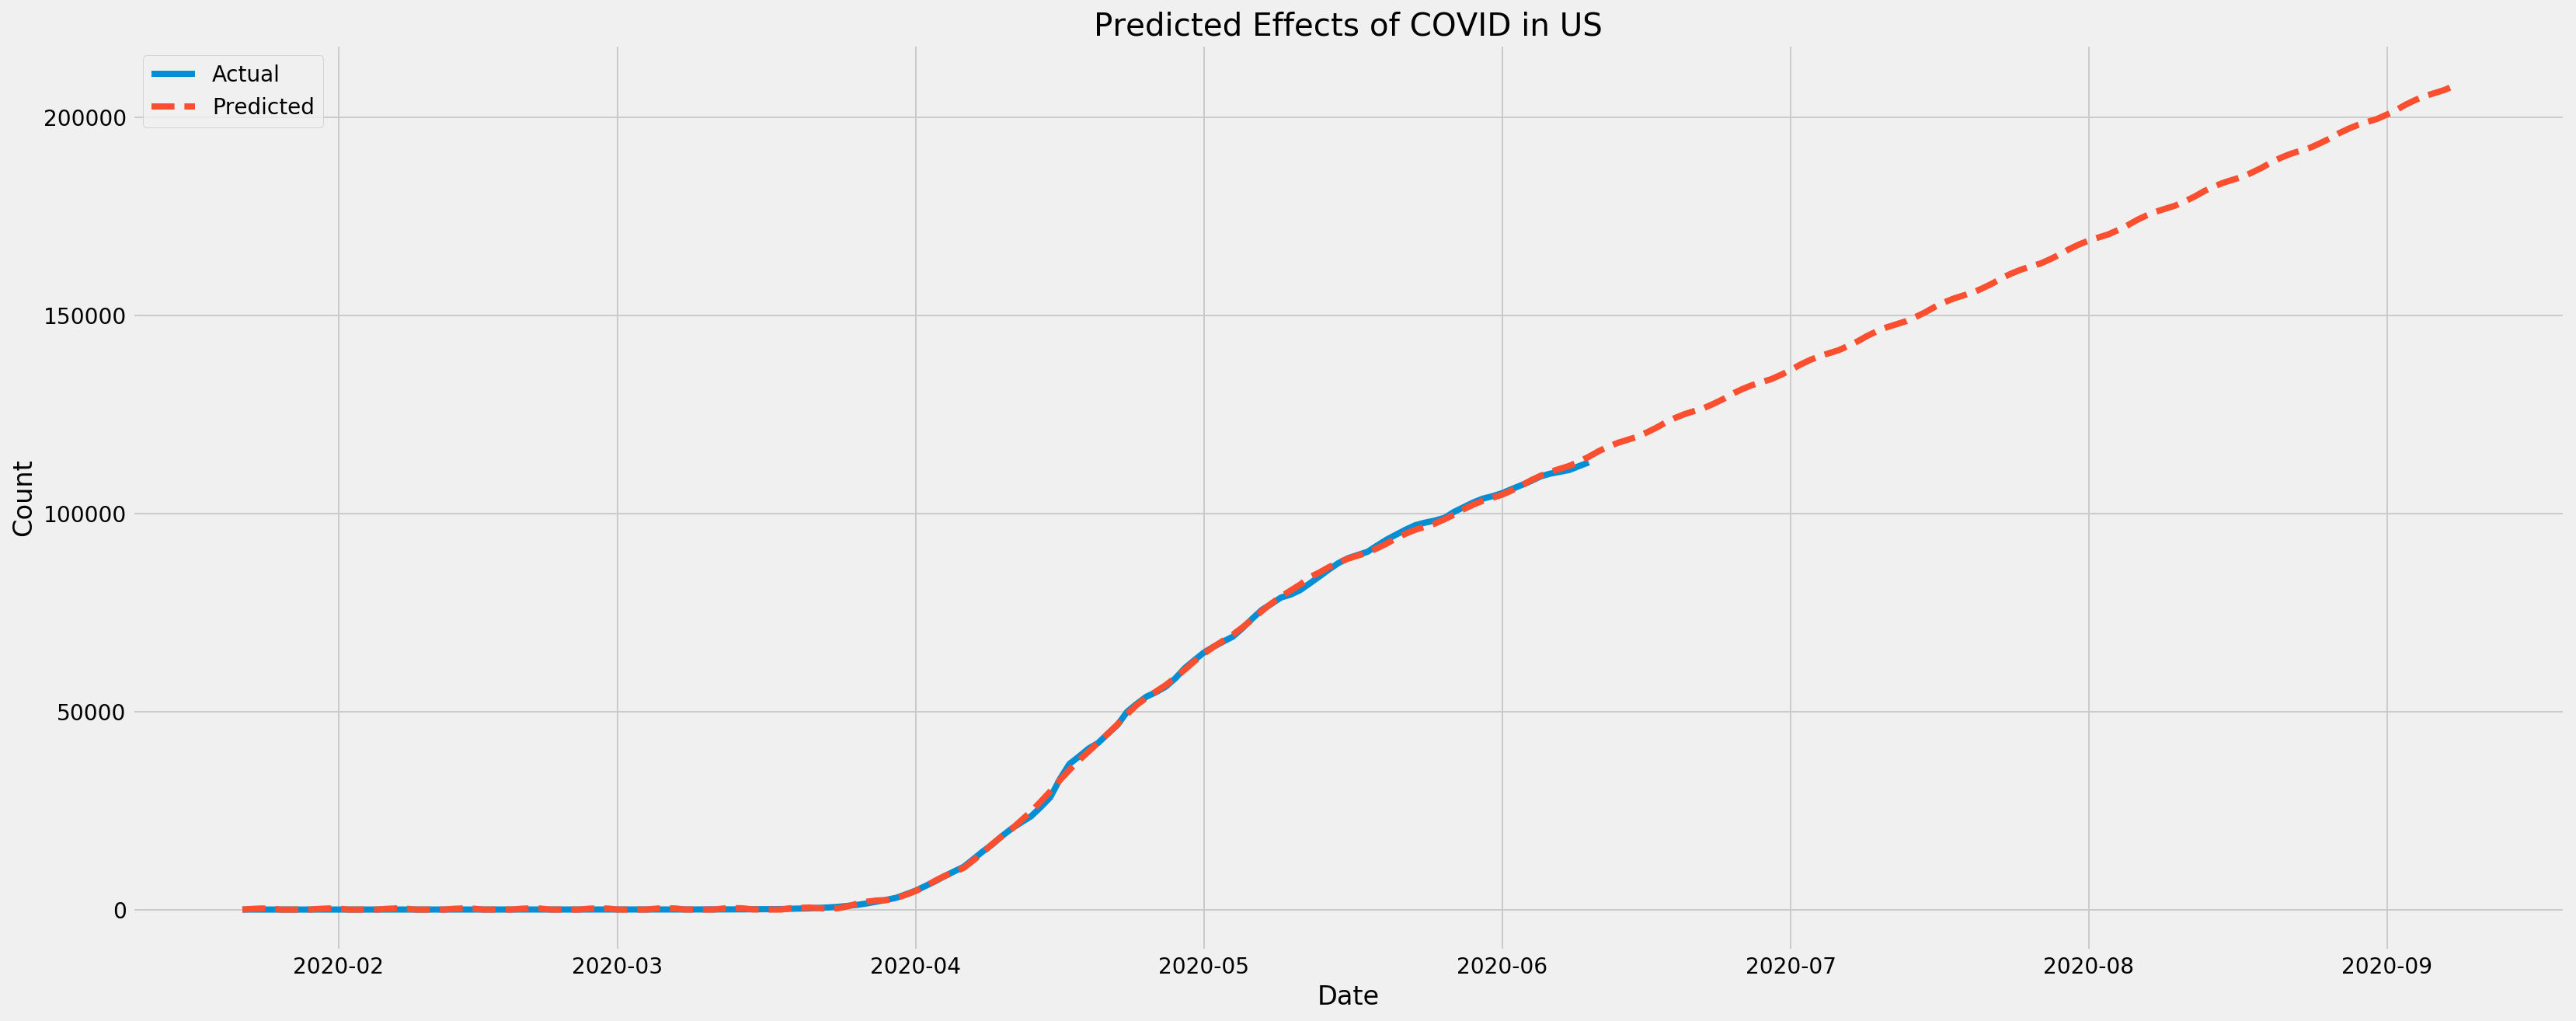

In [39]:
# Inspect
fig, ax = plt.subplots(figsize = [25, 10])
ax.plot(output['US'].set_index('ds')['y'], label = 'Actual')
ax.plot(output['US'].set_index('ds')['yhat'], label = 'Predicted', linestyle = '--')
ax.legend()
ax.set_title('Predicted Effects of COVID in US')
ax.set_xlabel('Date')
ax.set_ylabel('Count');

In [57]:
%matplotlib agg
%matplotlib agg

# Visualize
viz = {}

for k, v in output.items():
    
    # Inspect
    fig, ax = plt.subplots(figsize = [25, 10])
    ax.plot(v.set_index('ds')['y'], label = 'Actual')
    ax.plot(v.set_index('ds')['yhat'], label = 'Predicted', linestyle = '--')
    ax.legend()
    ax.set_title('Predicted Effects of COVID in {}'.format(k))
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    plt.close()
    
    # Update
    viz[k] = fig

In [48]:
# Save session
dill.dump_session('covid_fcst_fin.pkl')

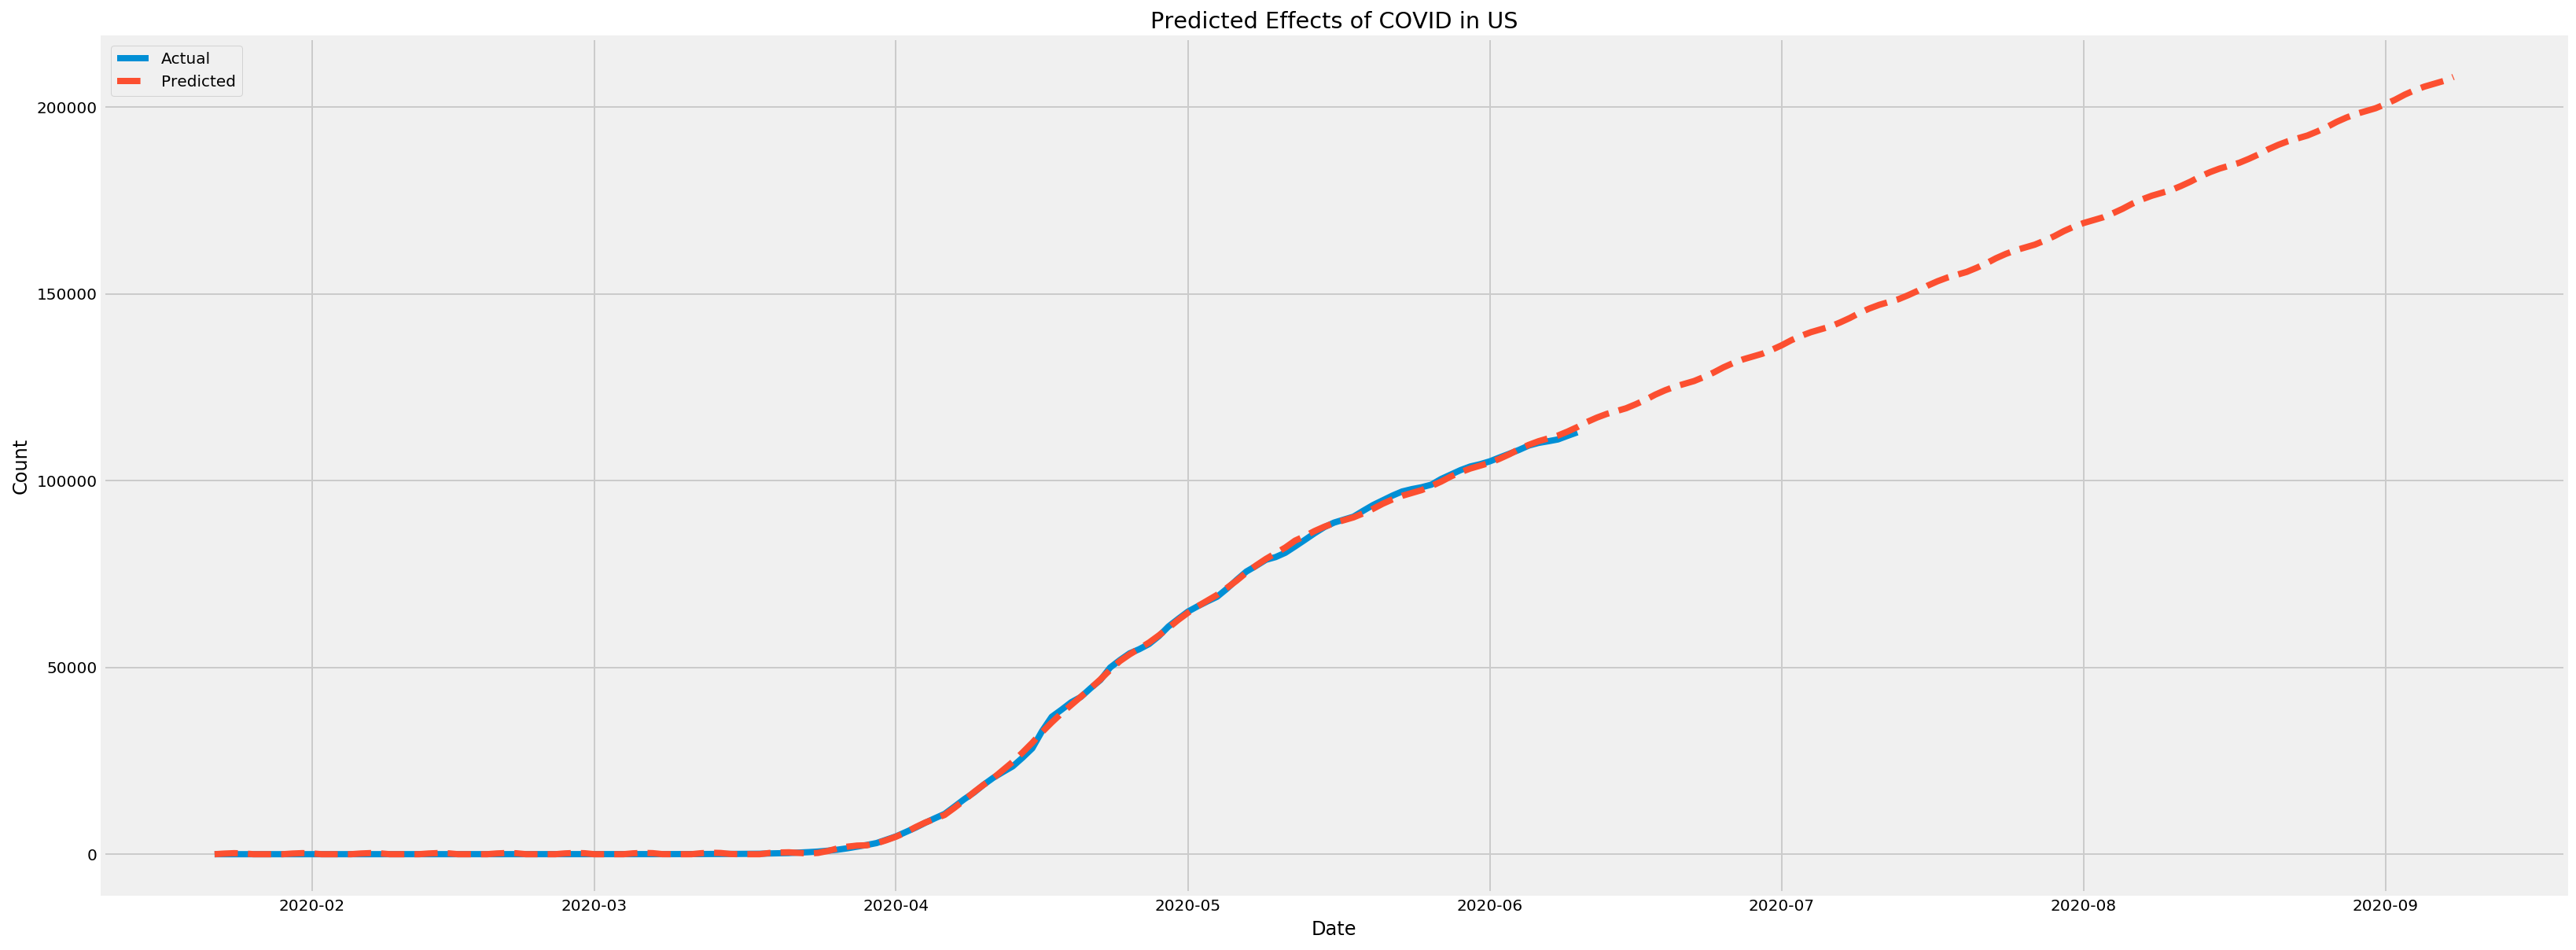

In [52]:
viz['US']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



KeyboardInterrupt: 

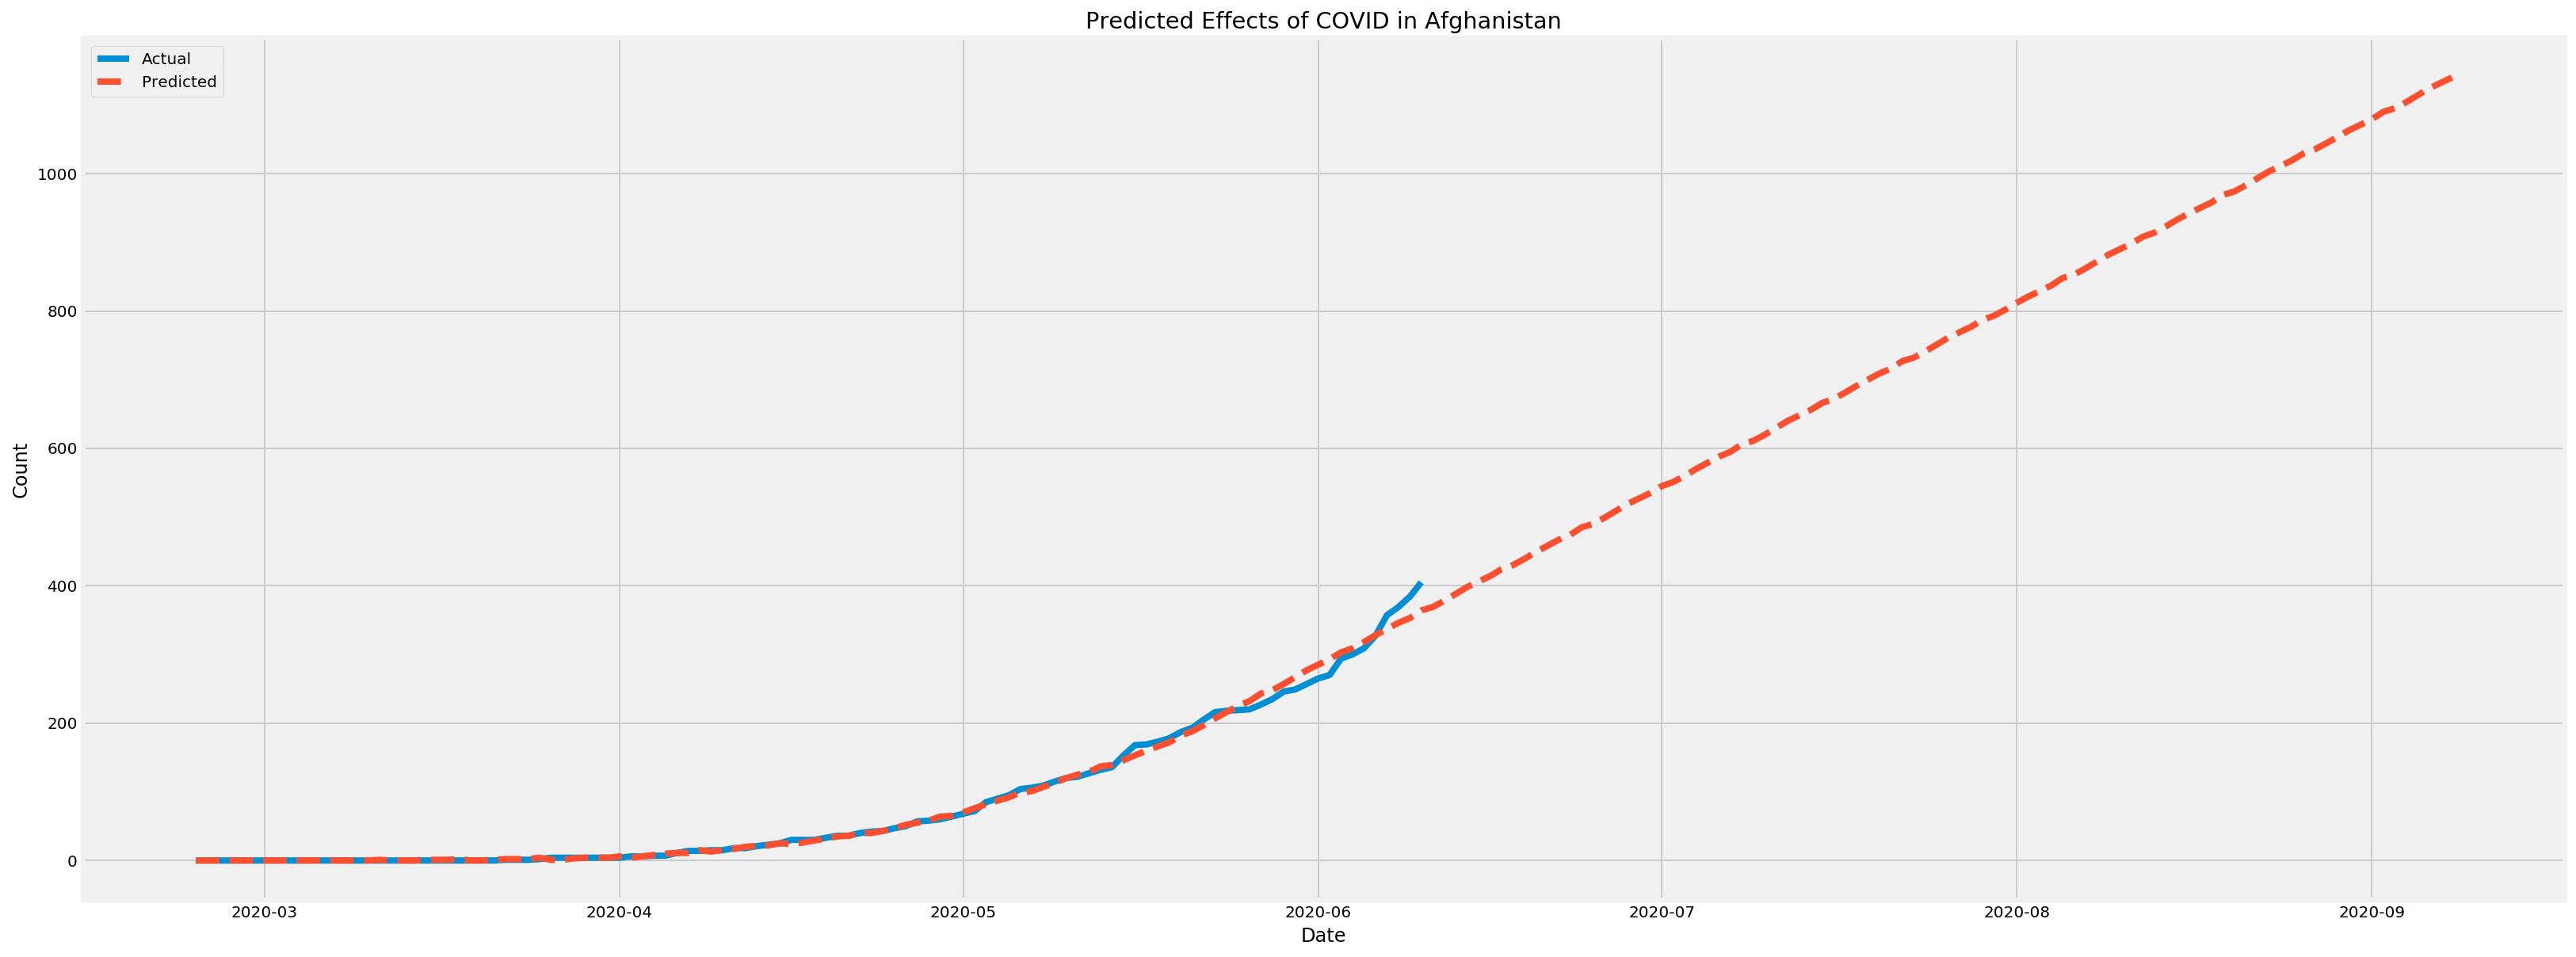

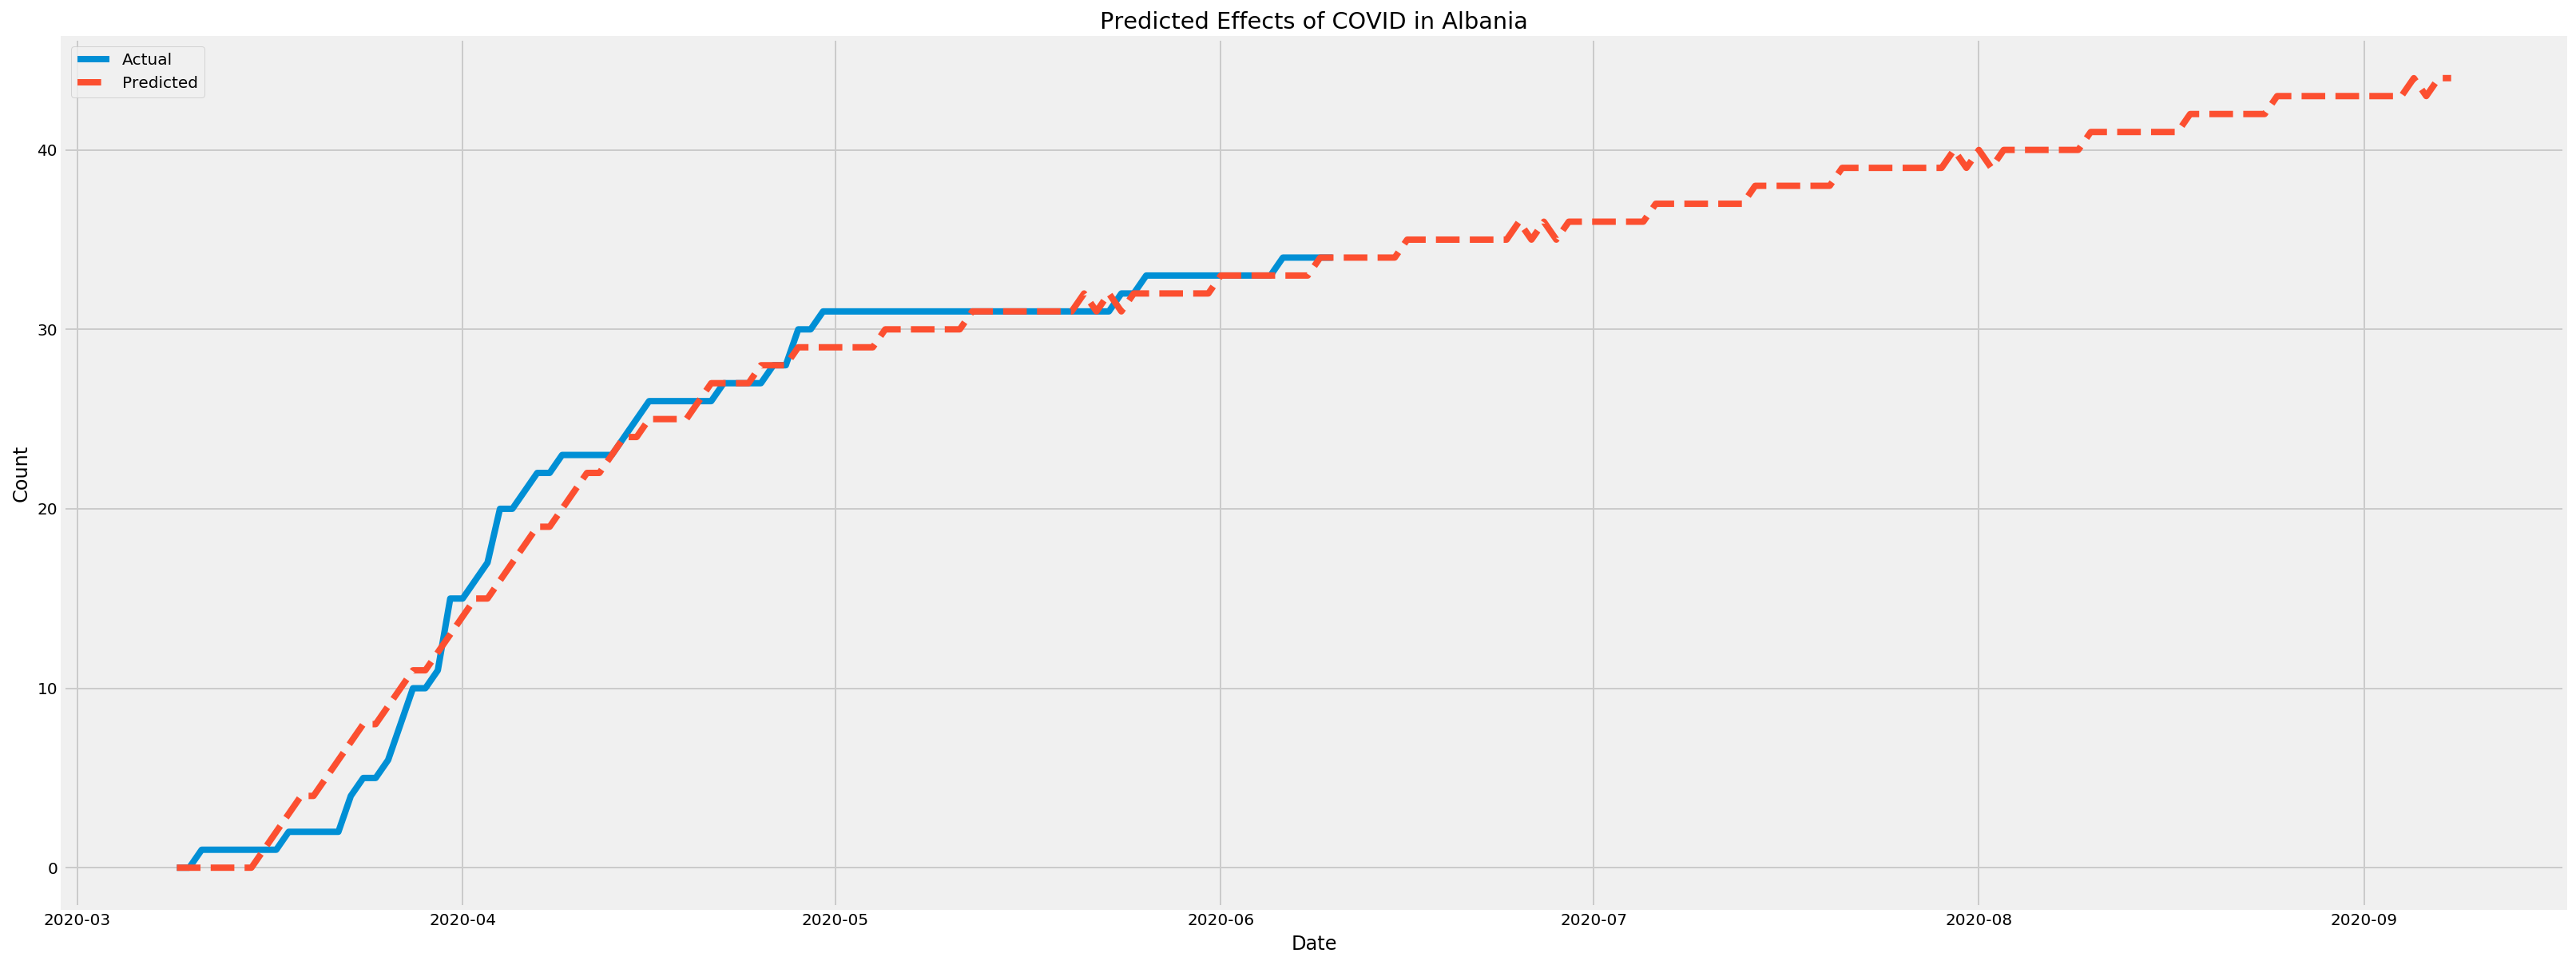

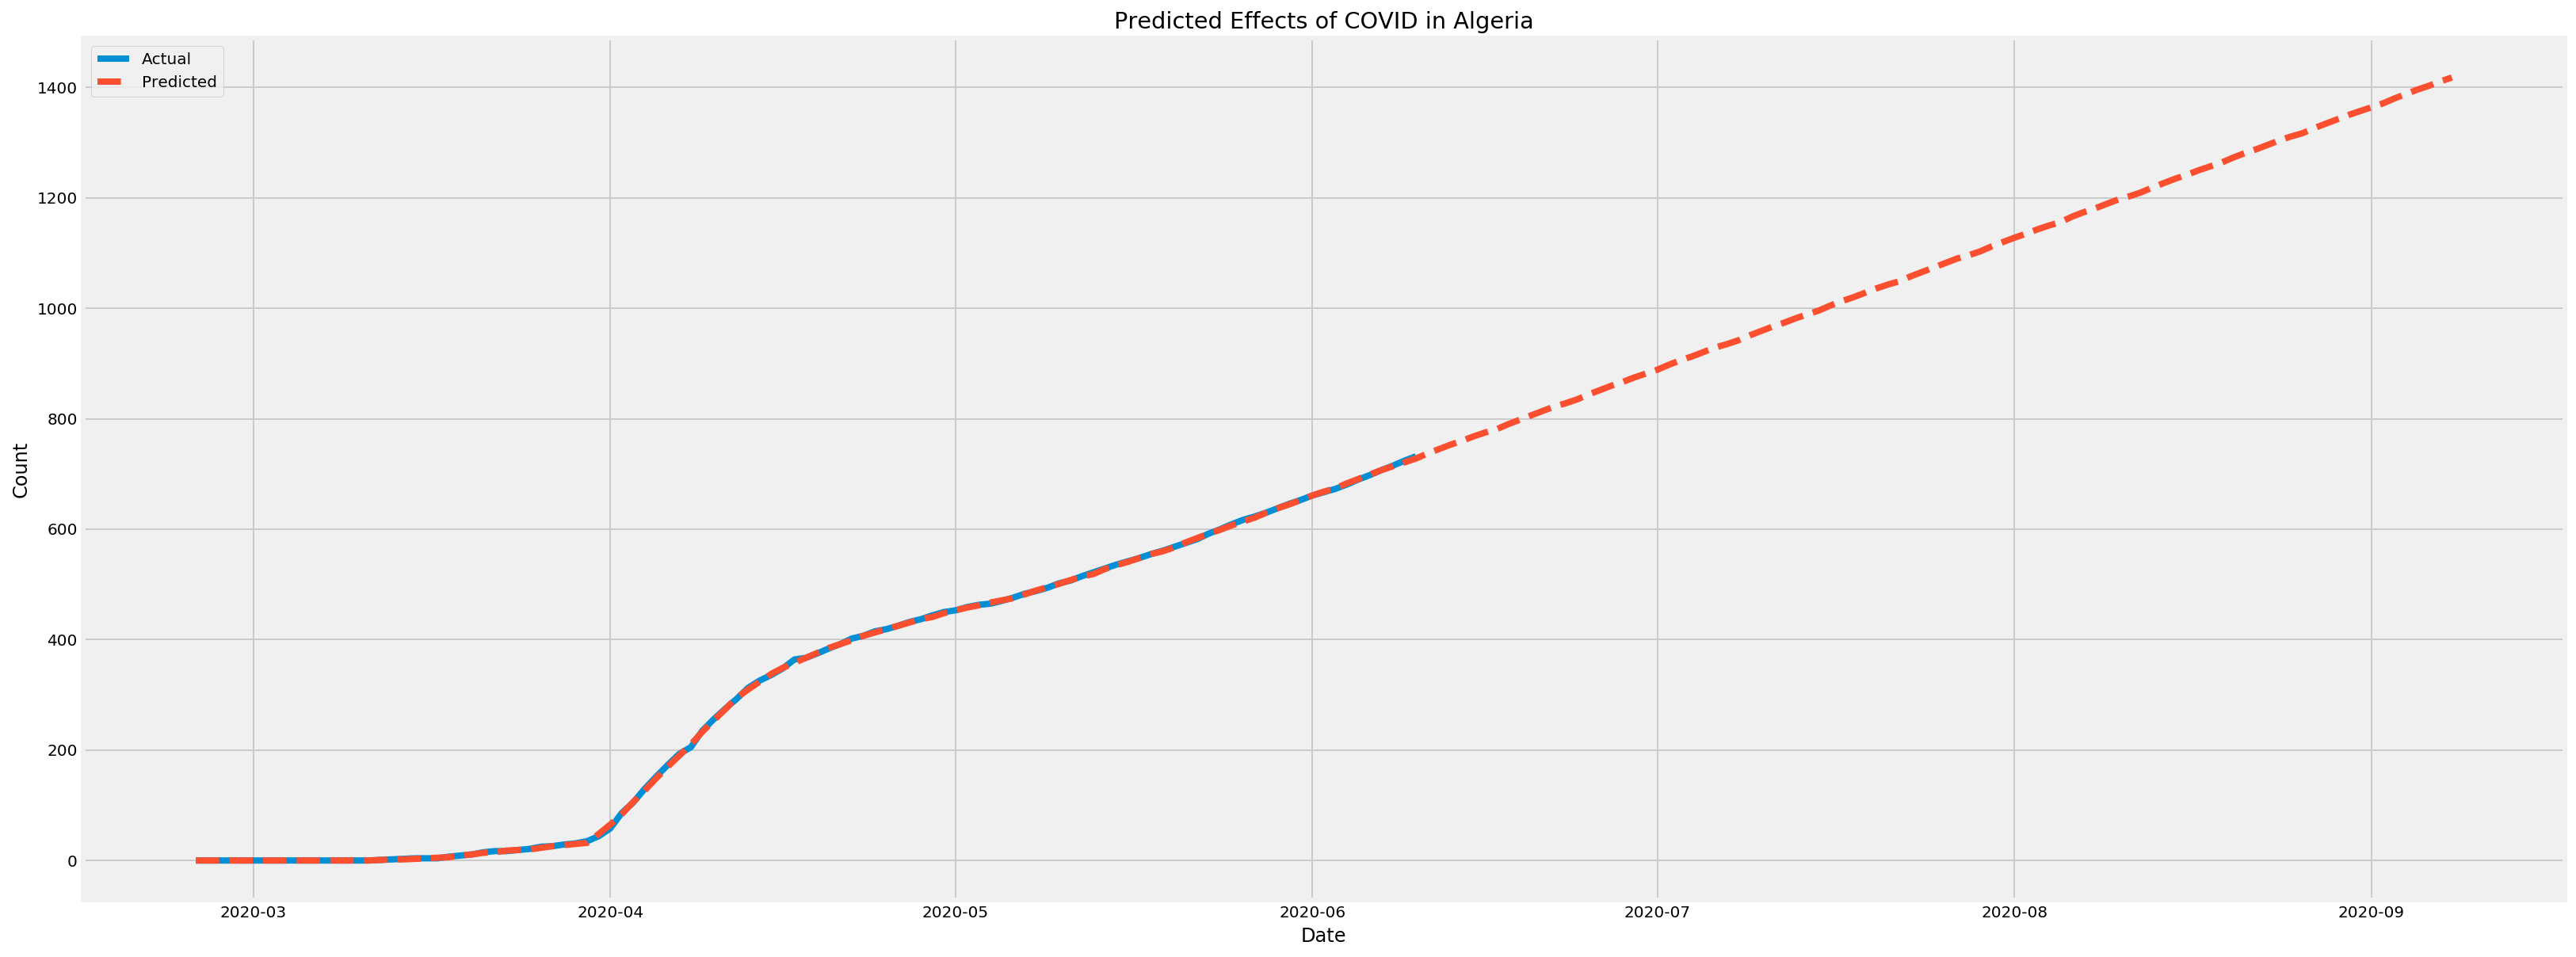

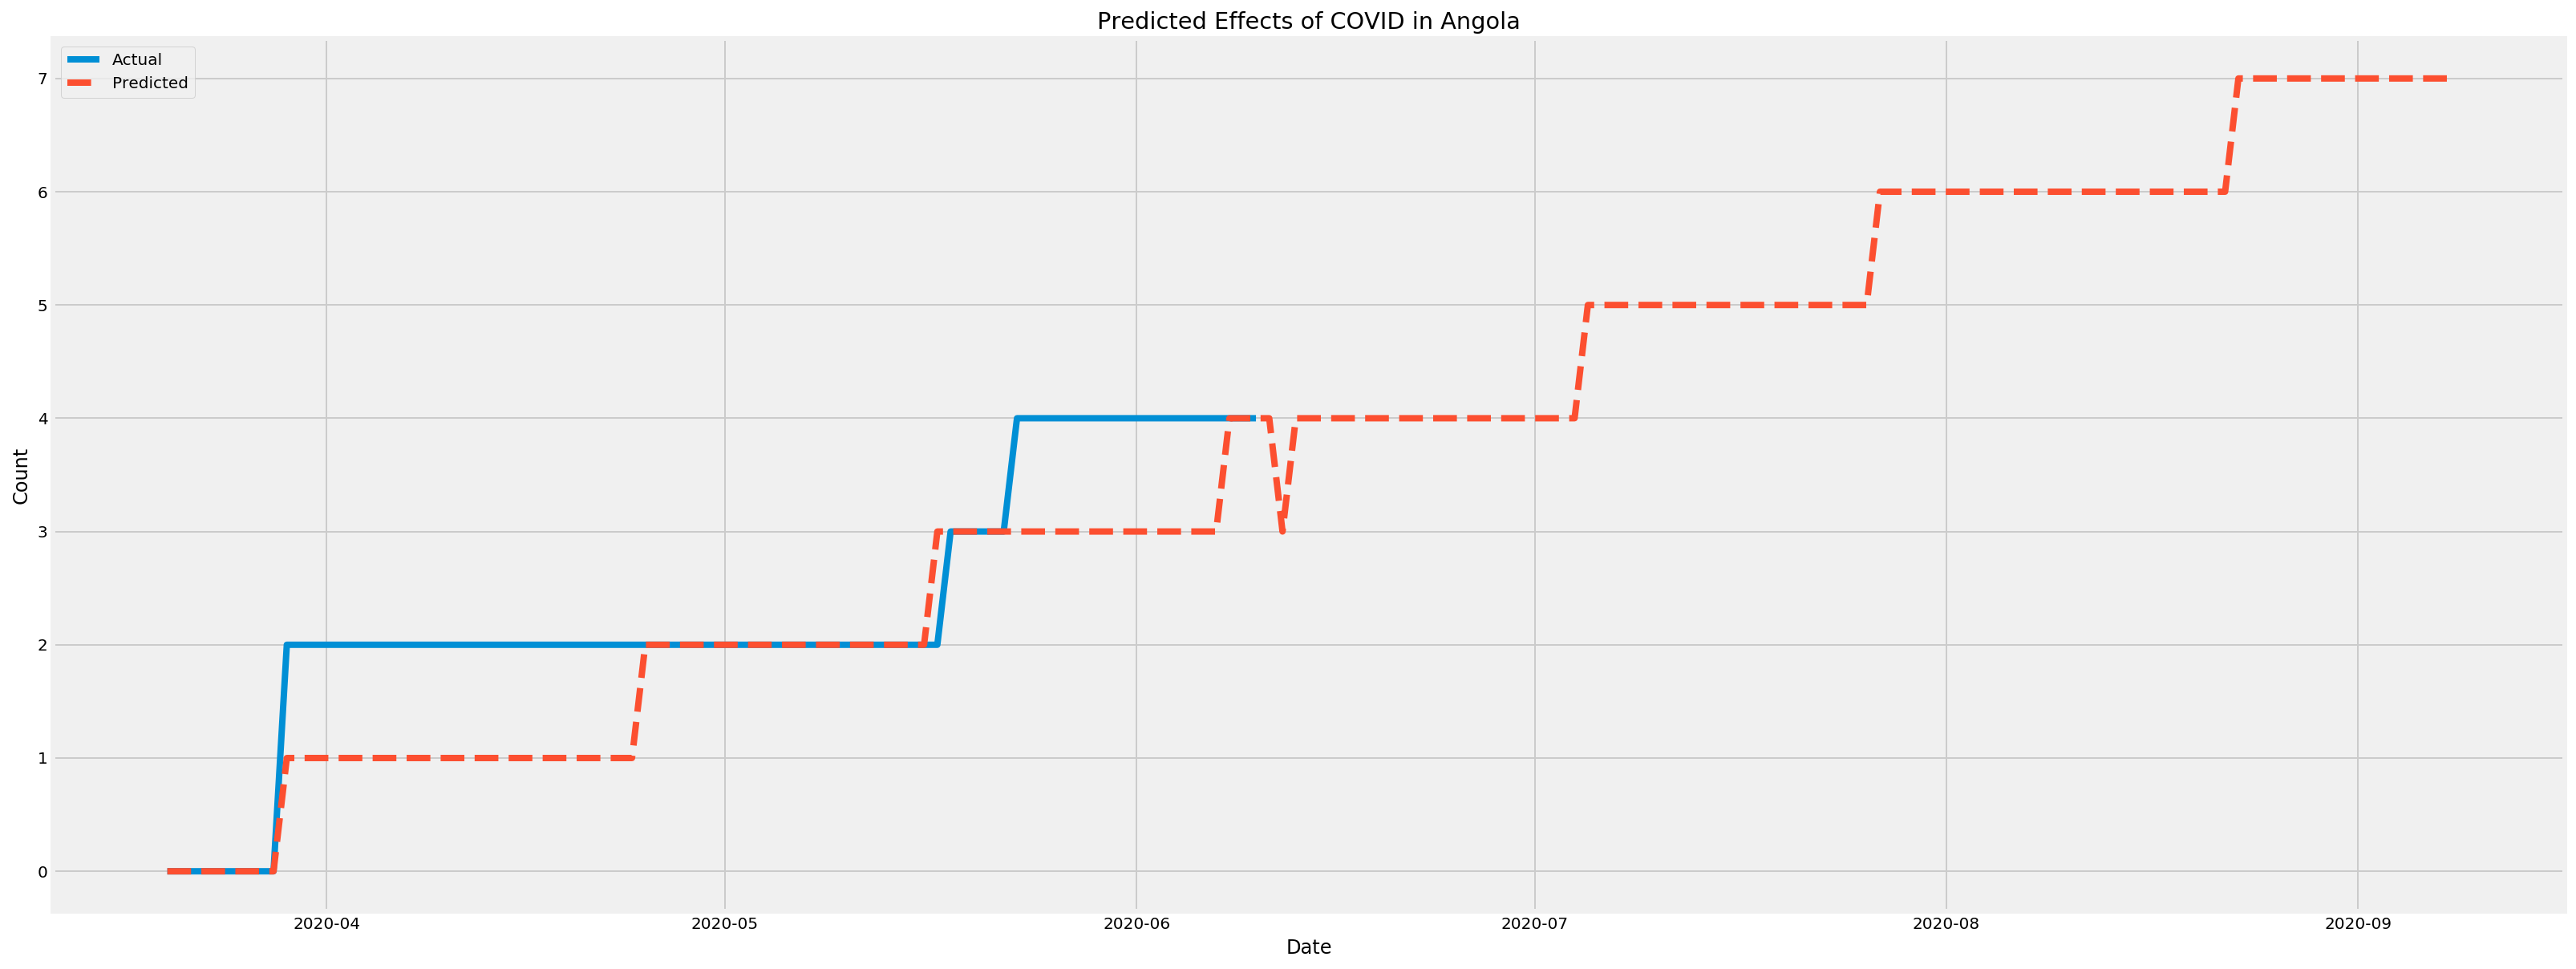

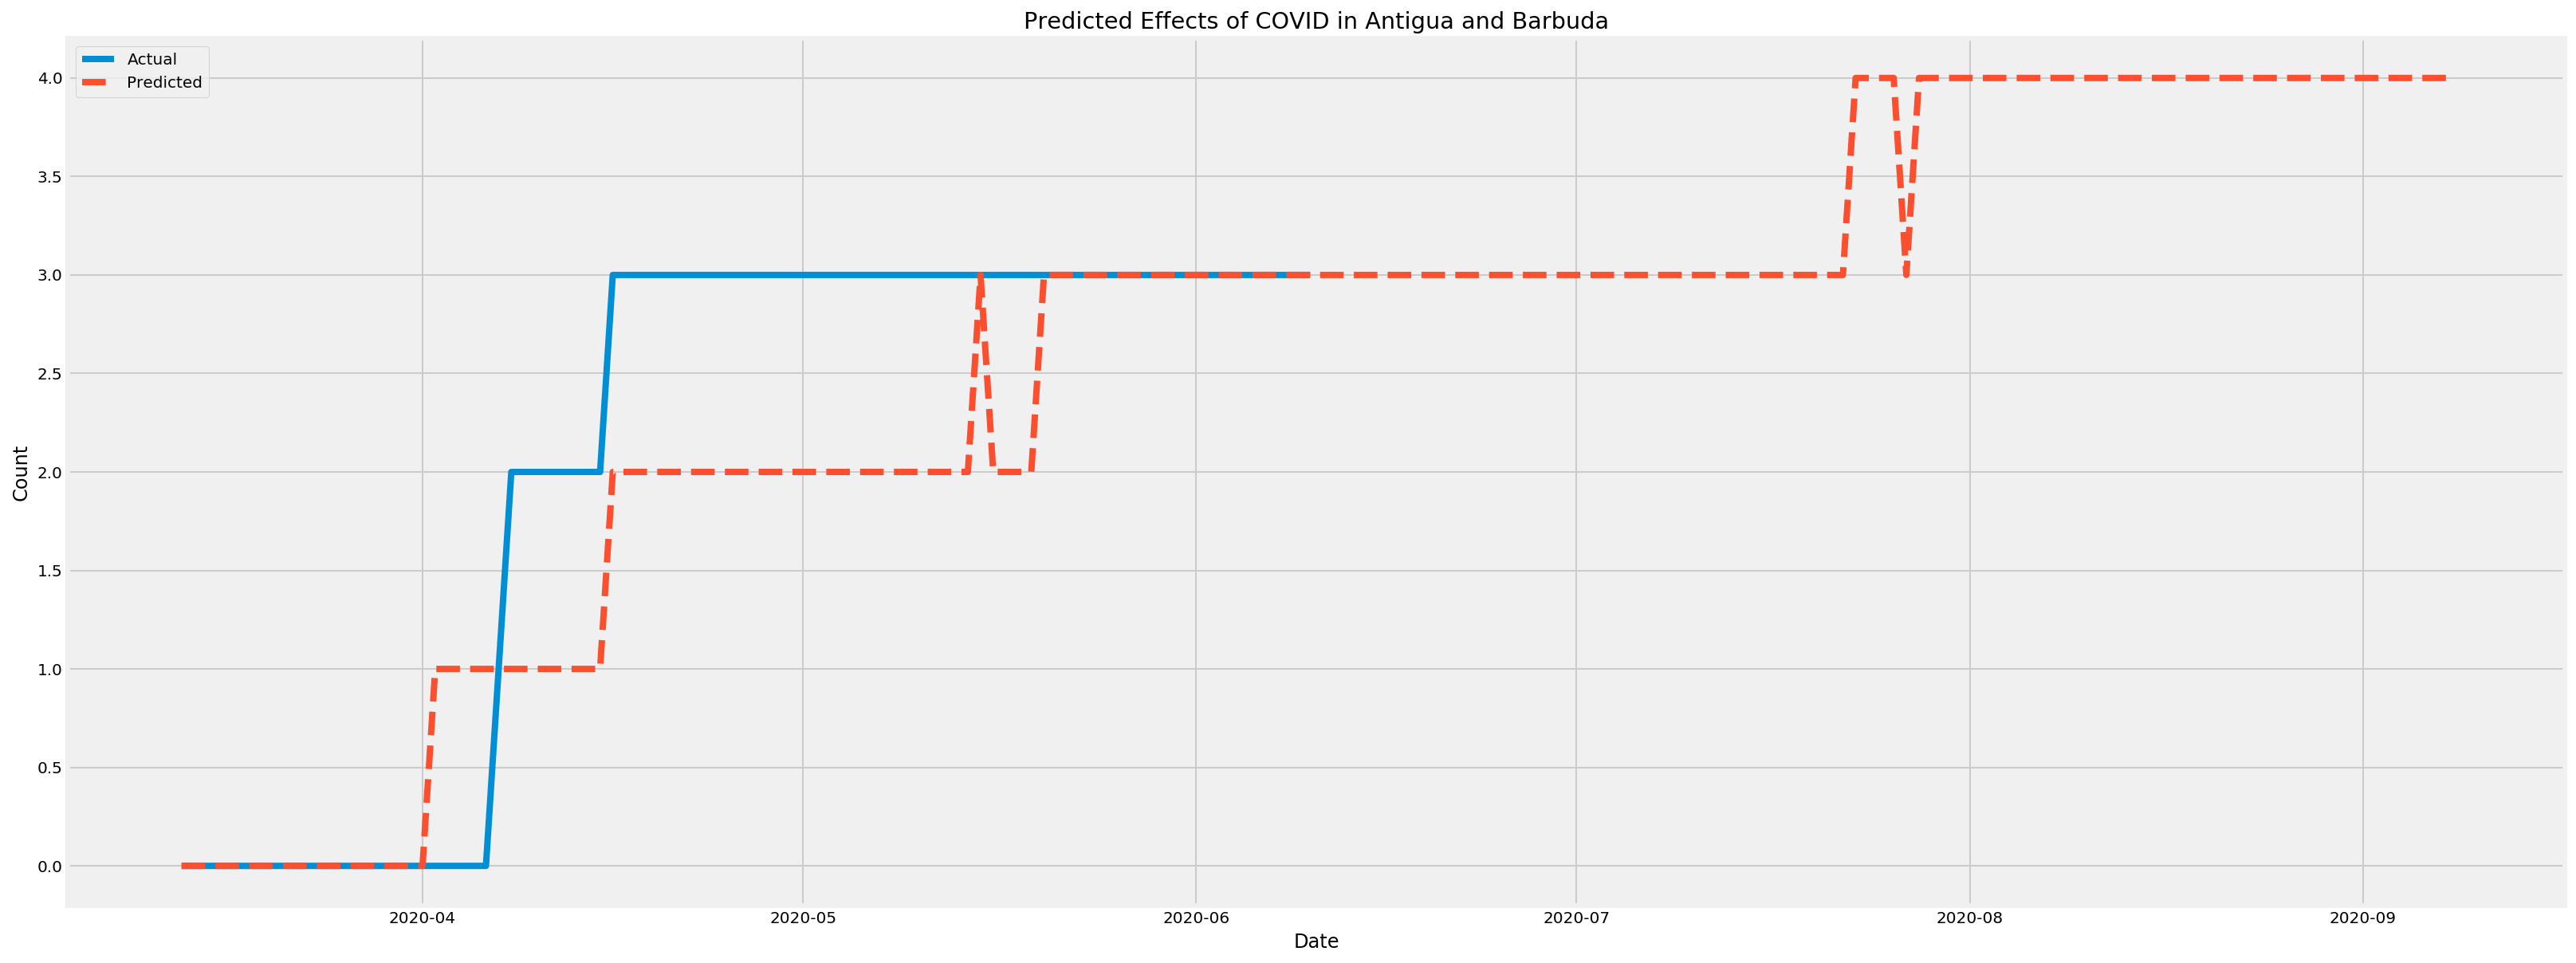

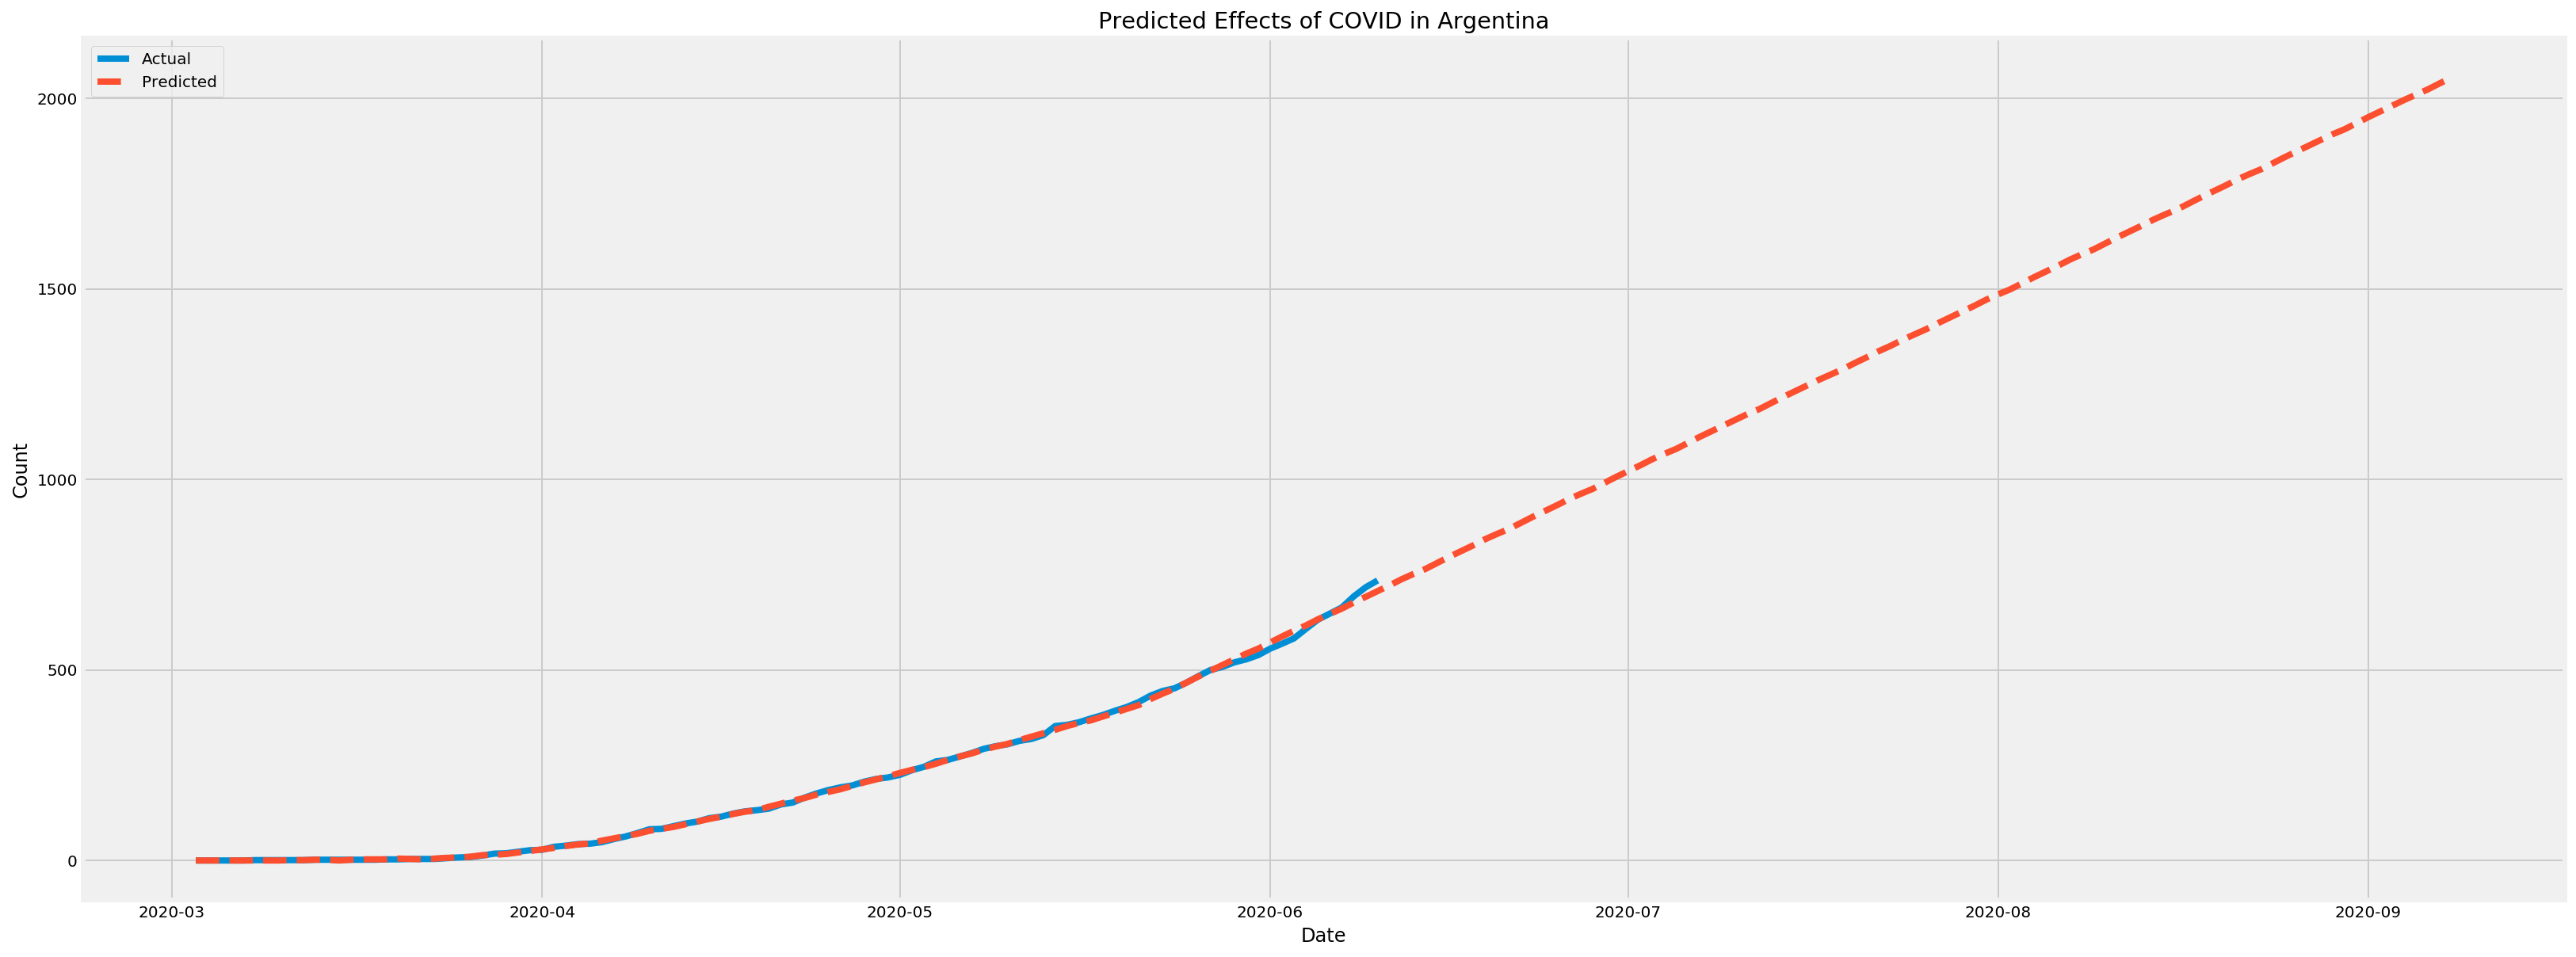

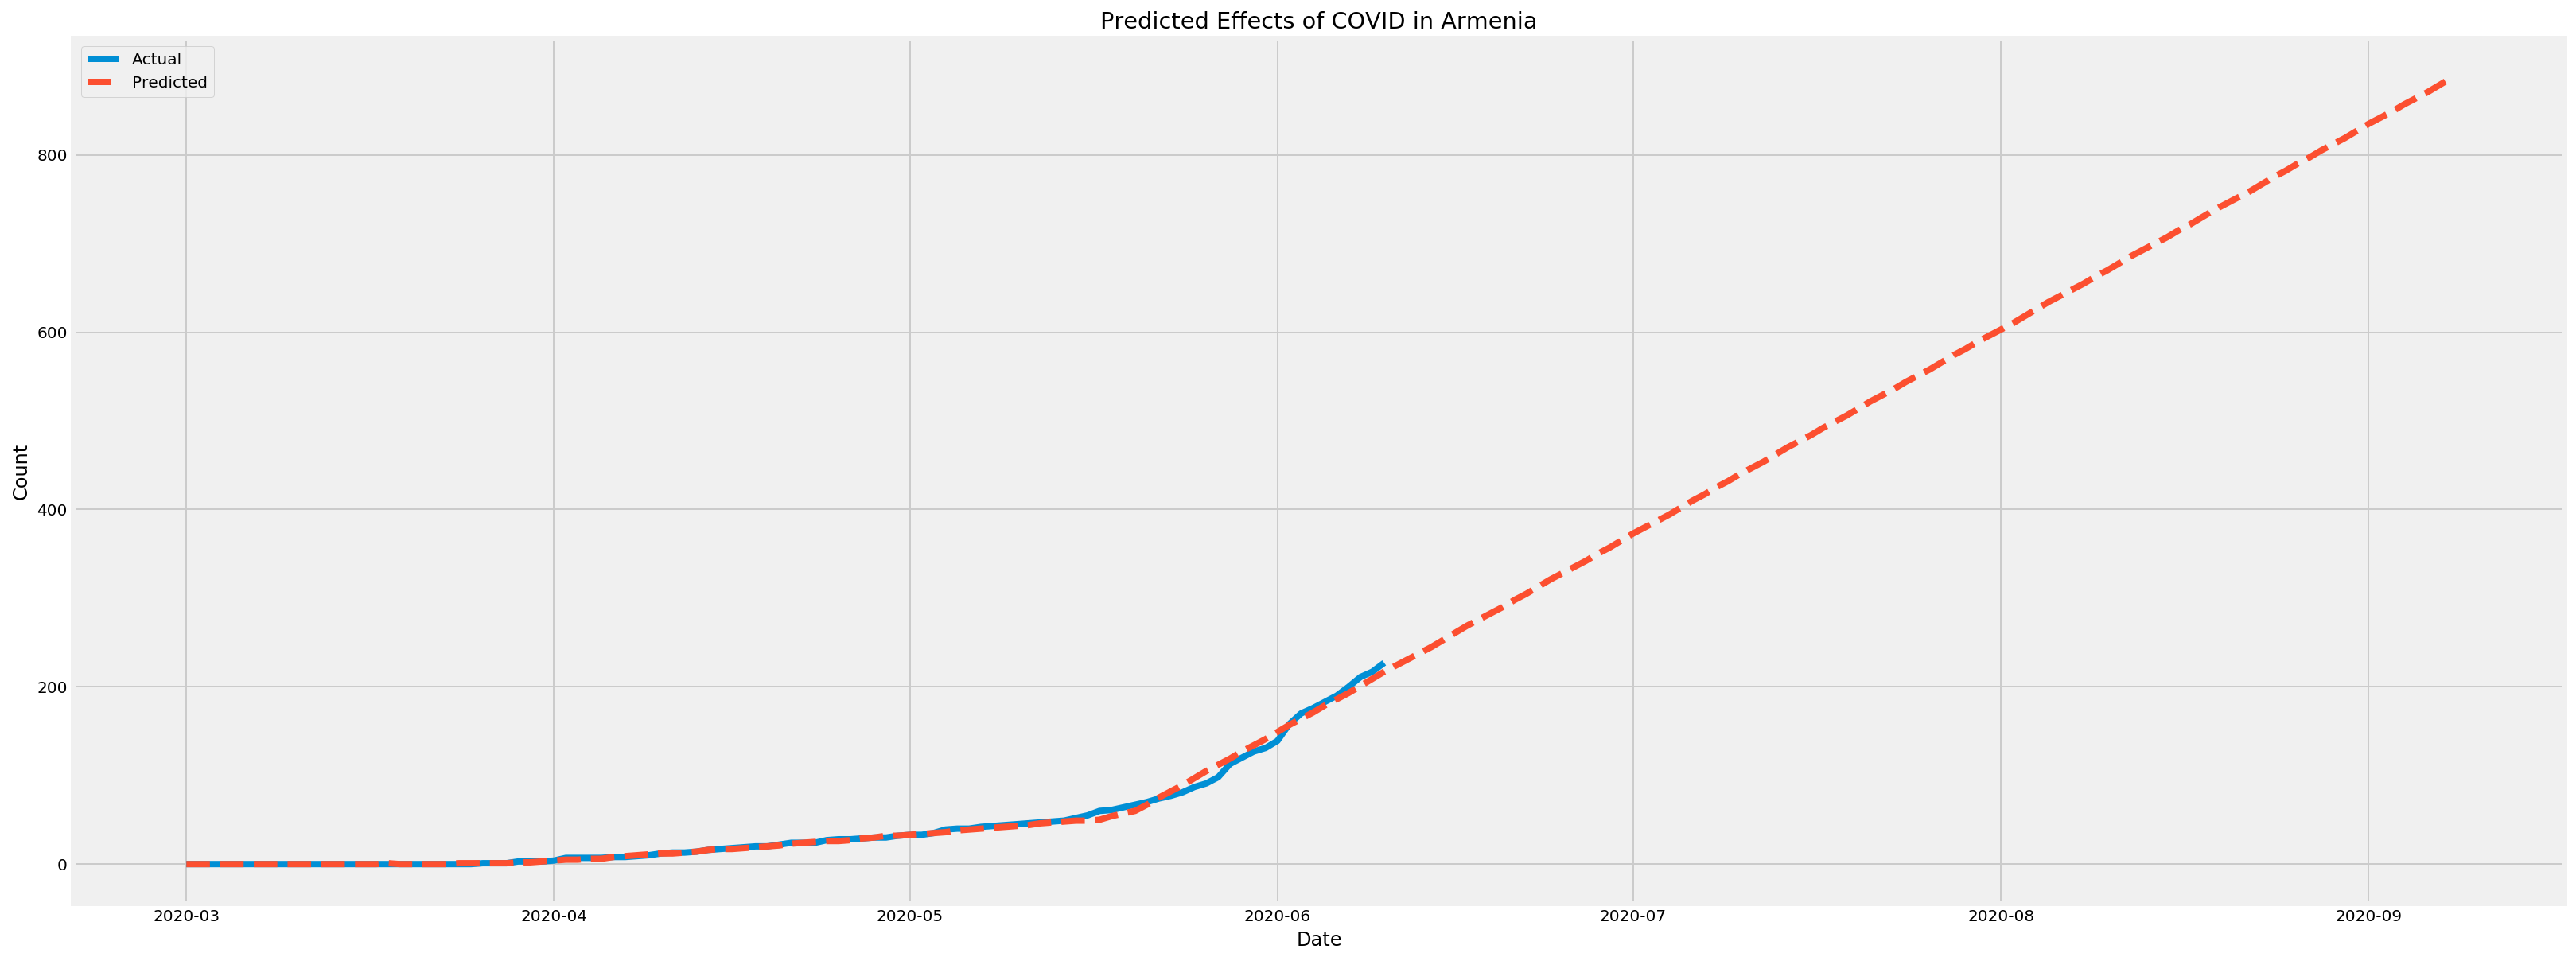

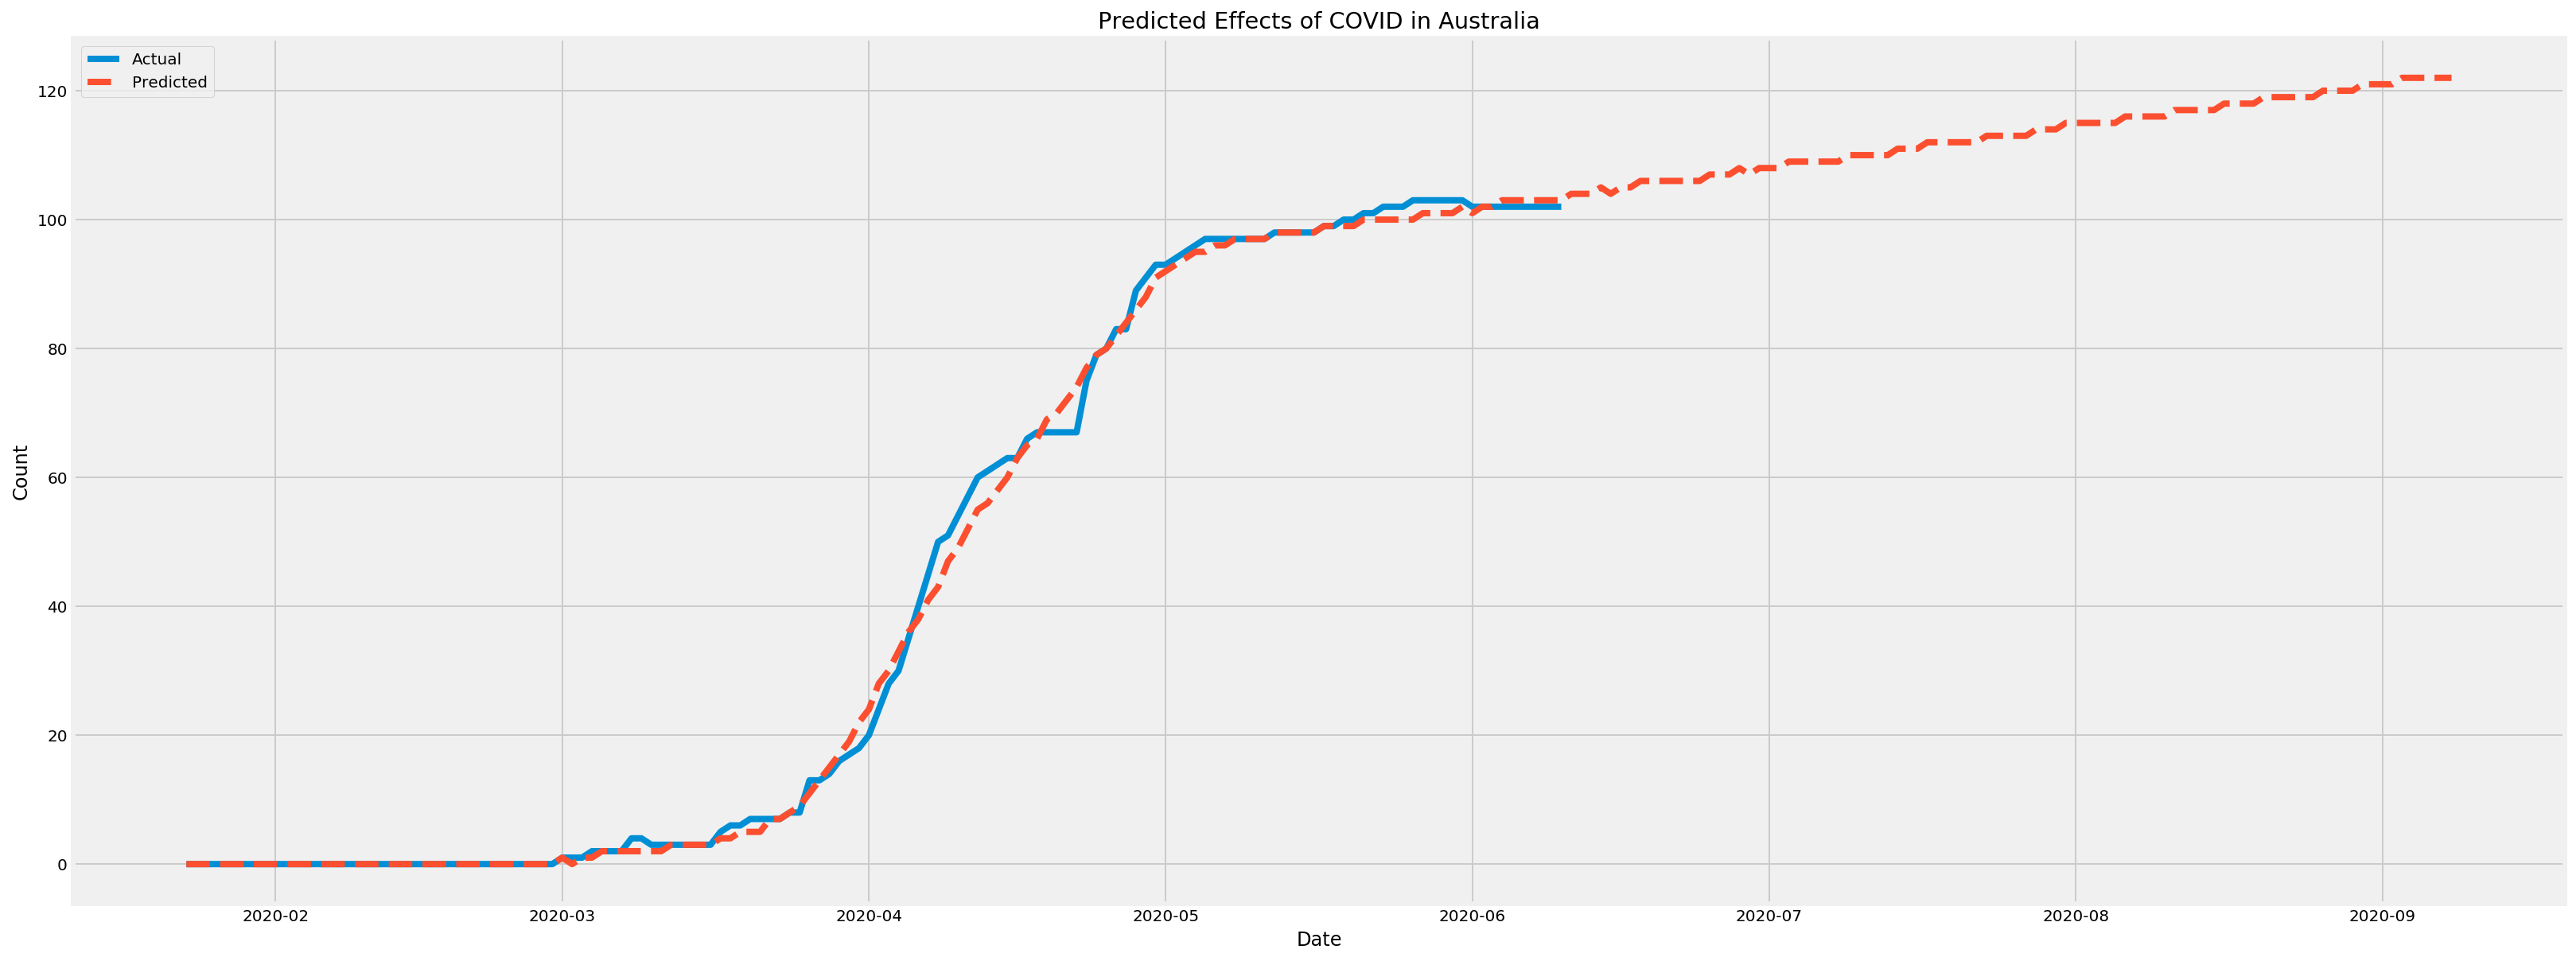

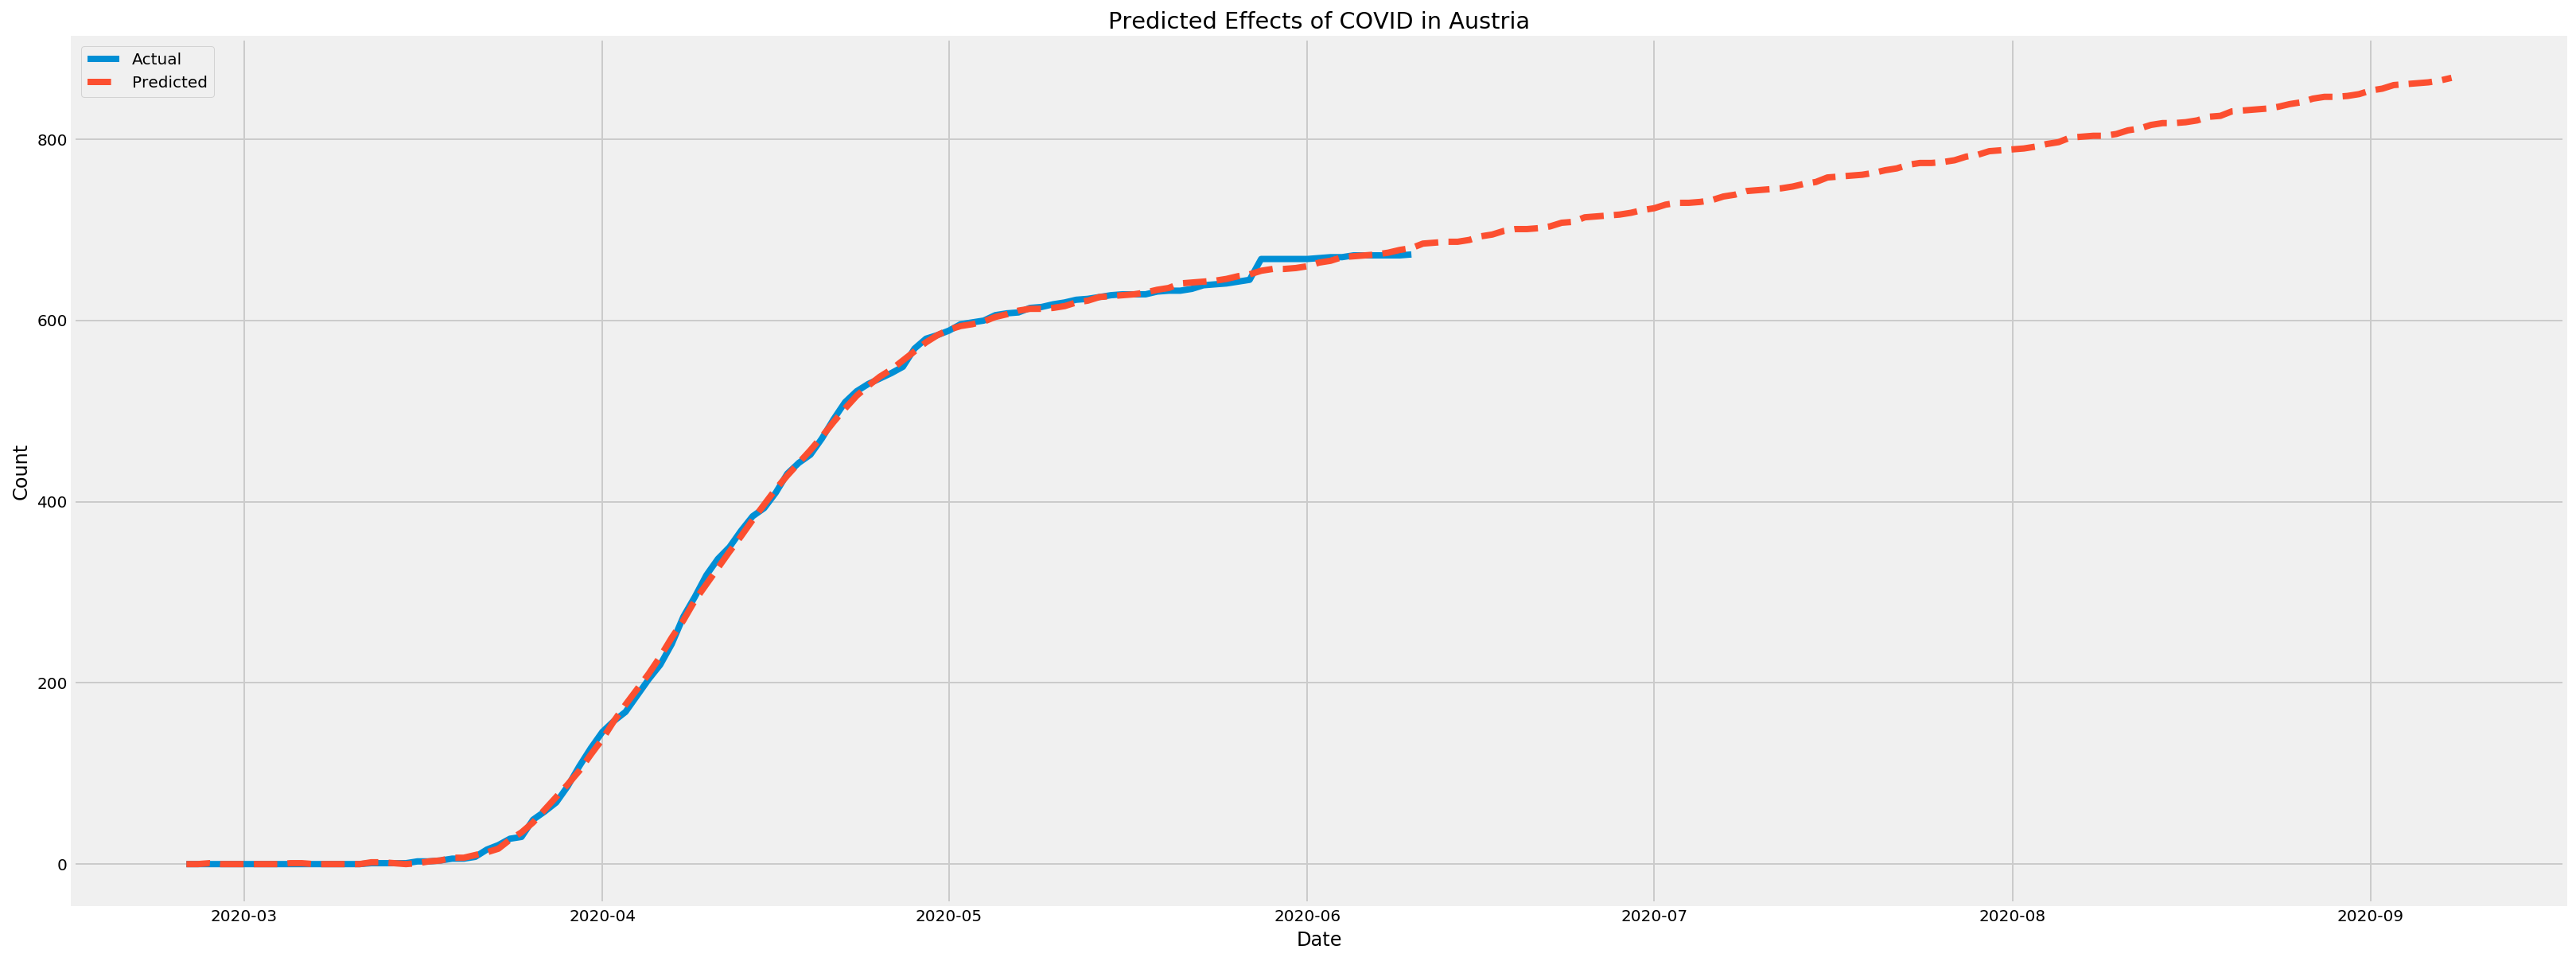

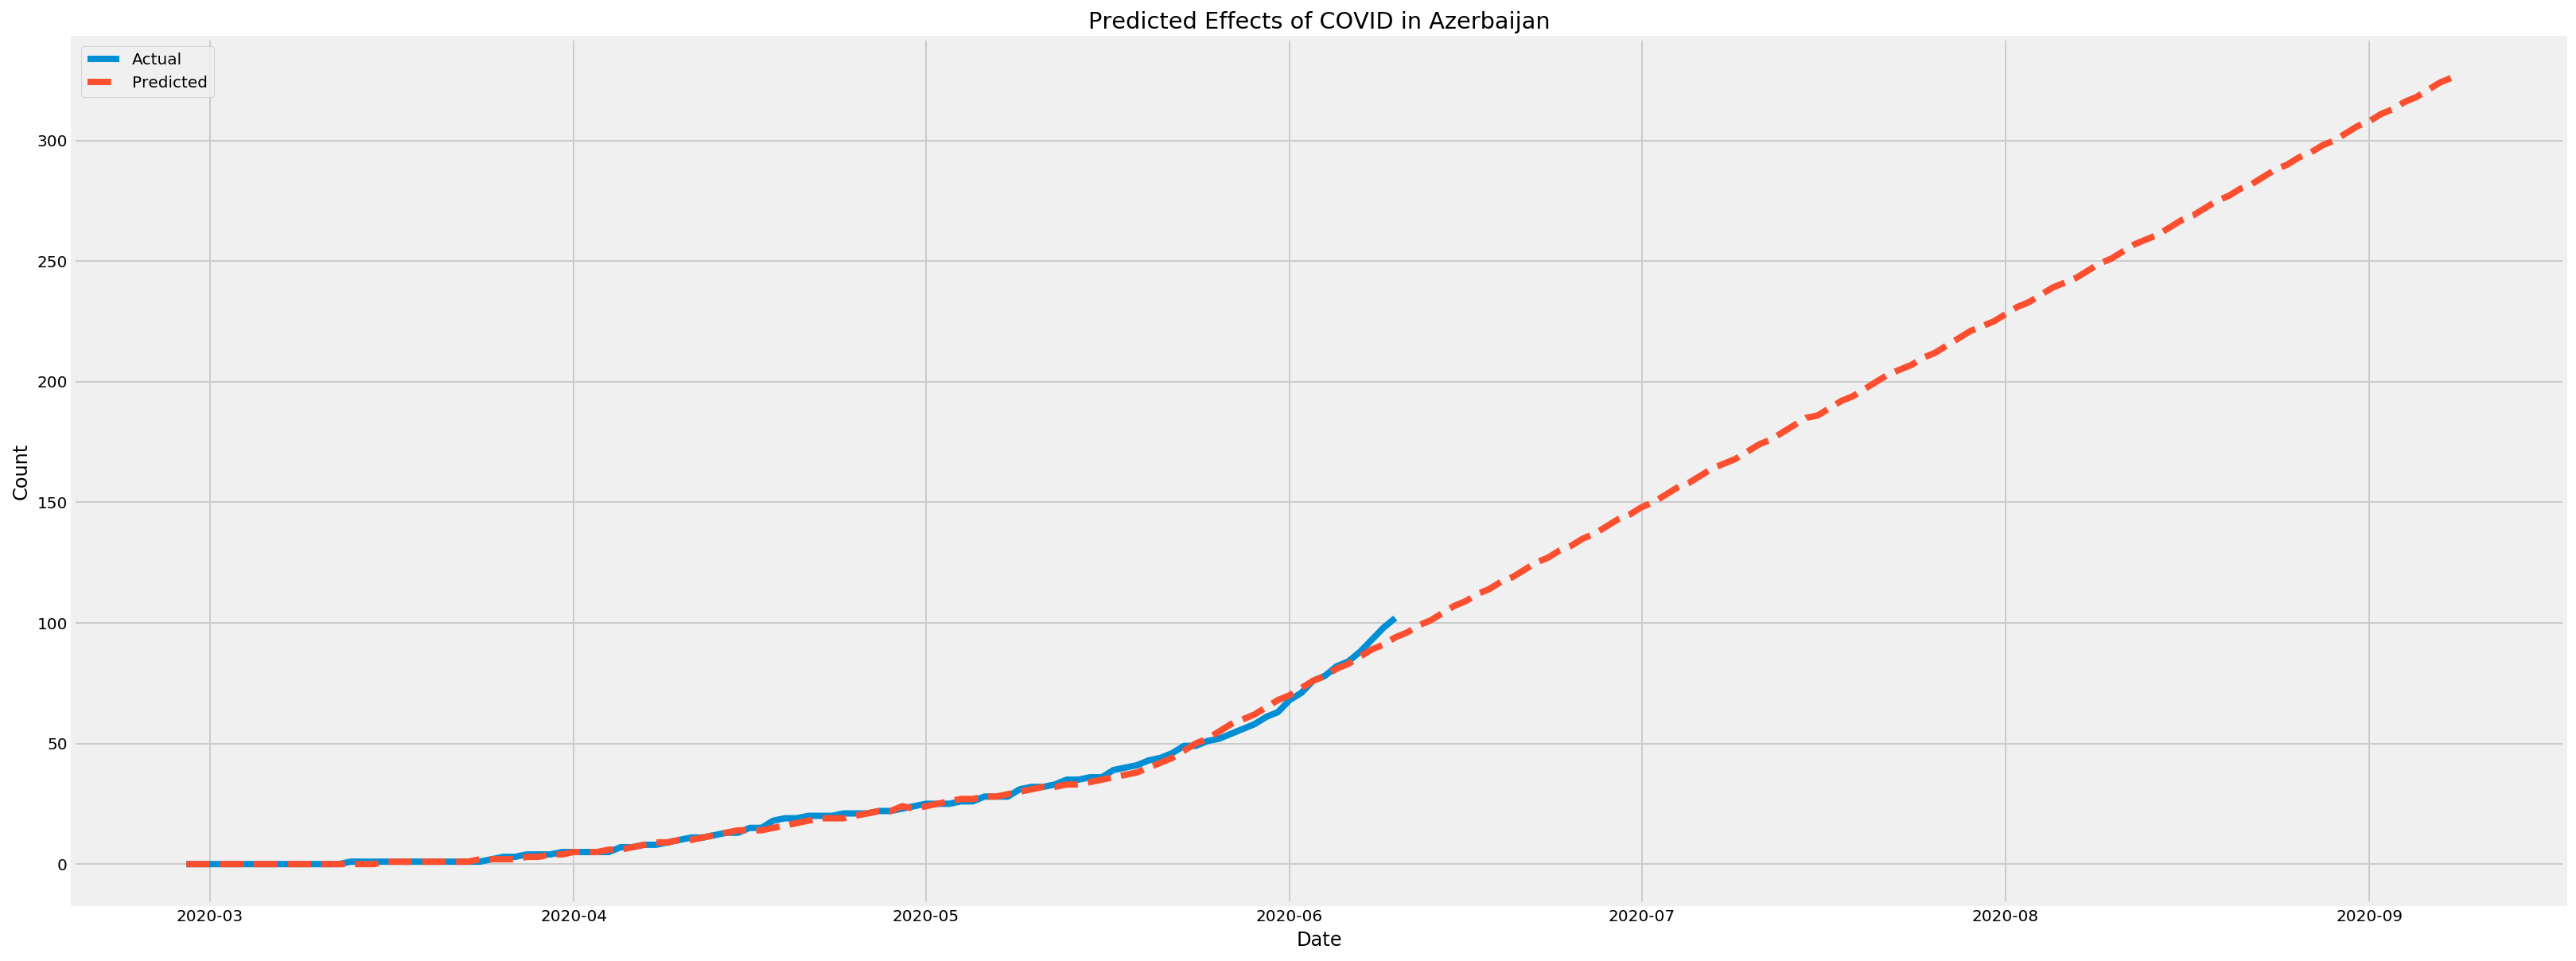

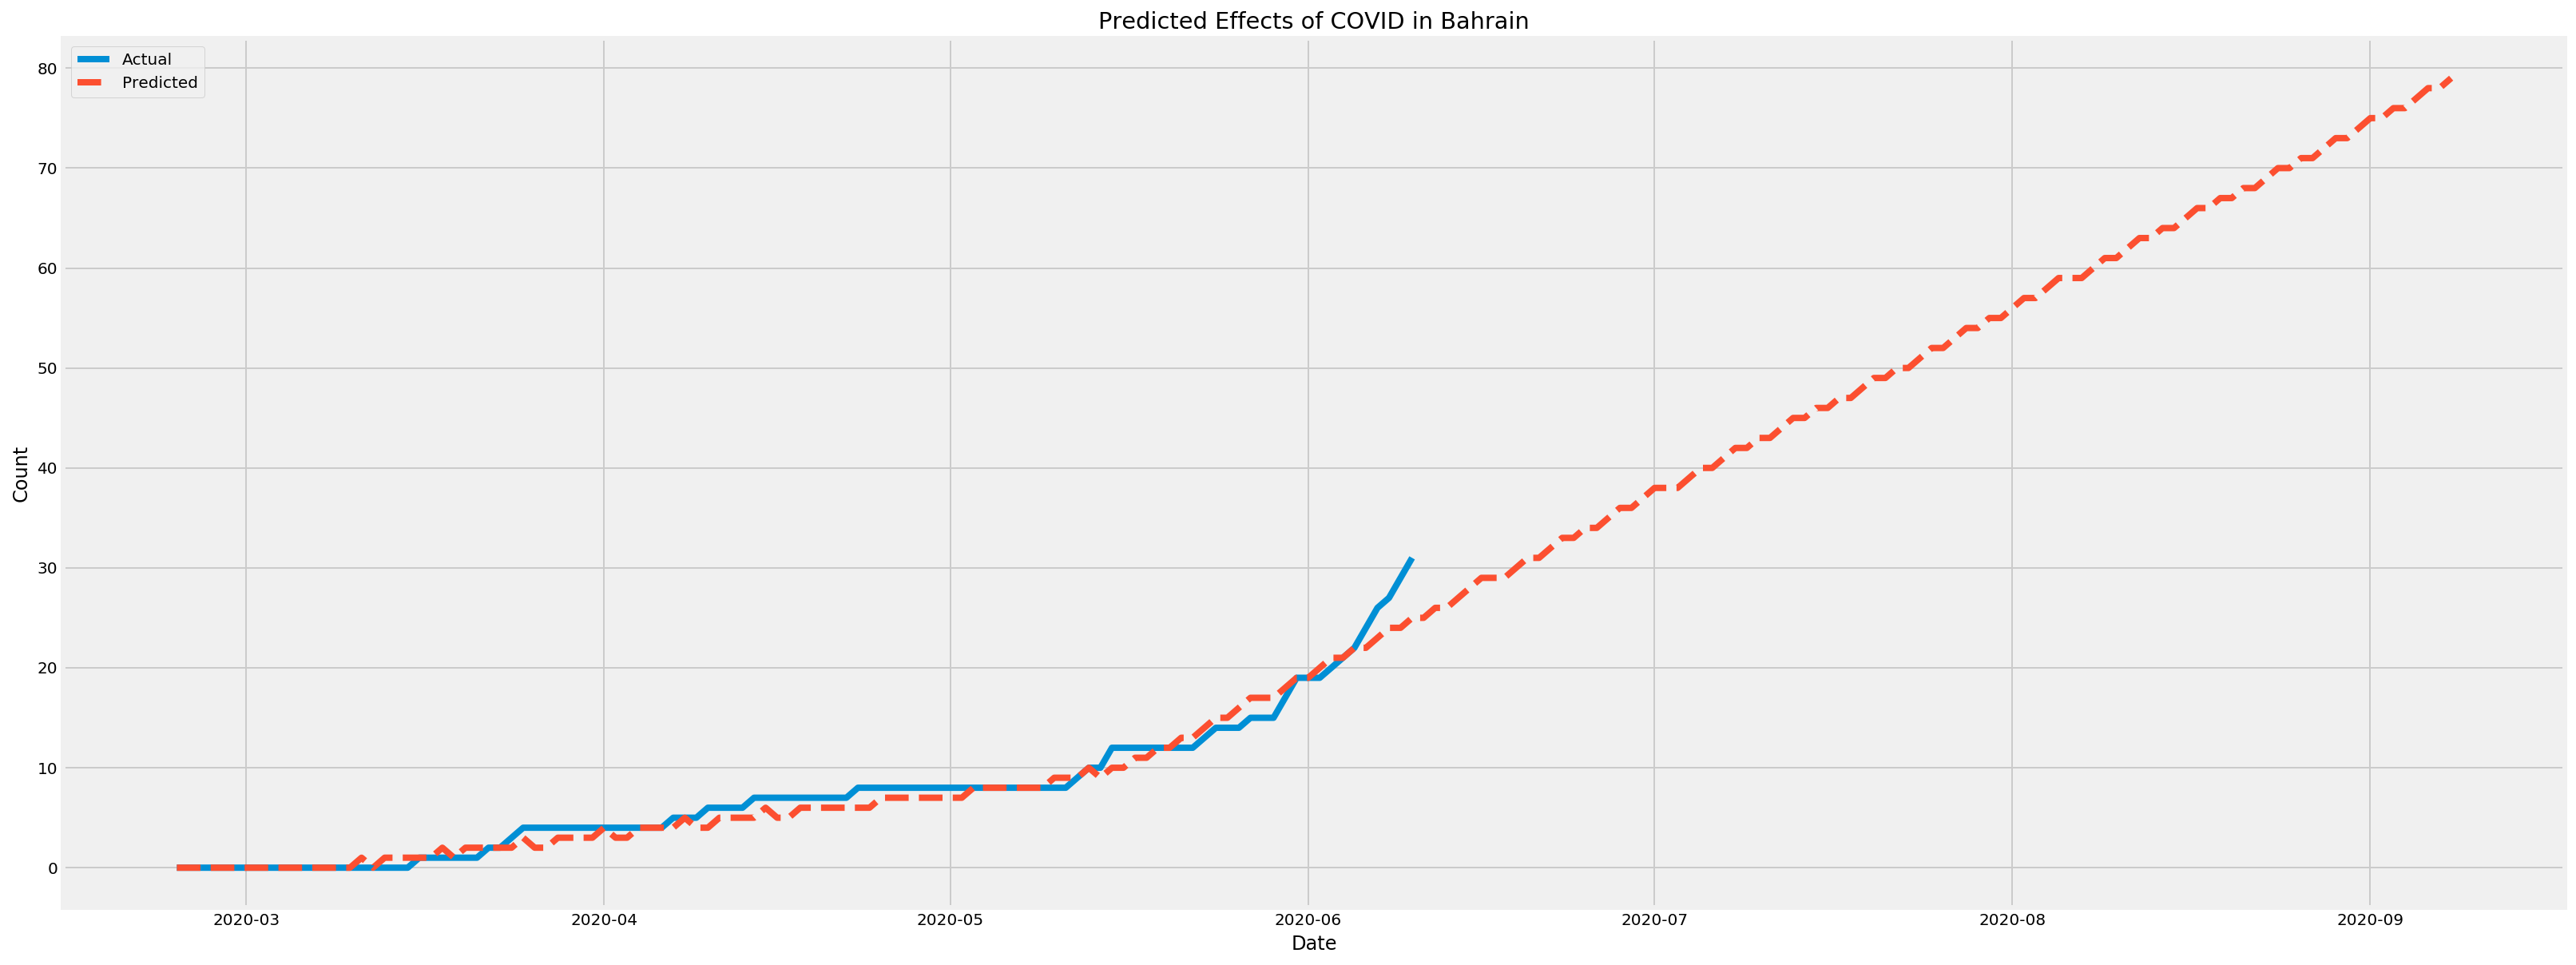

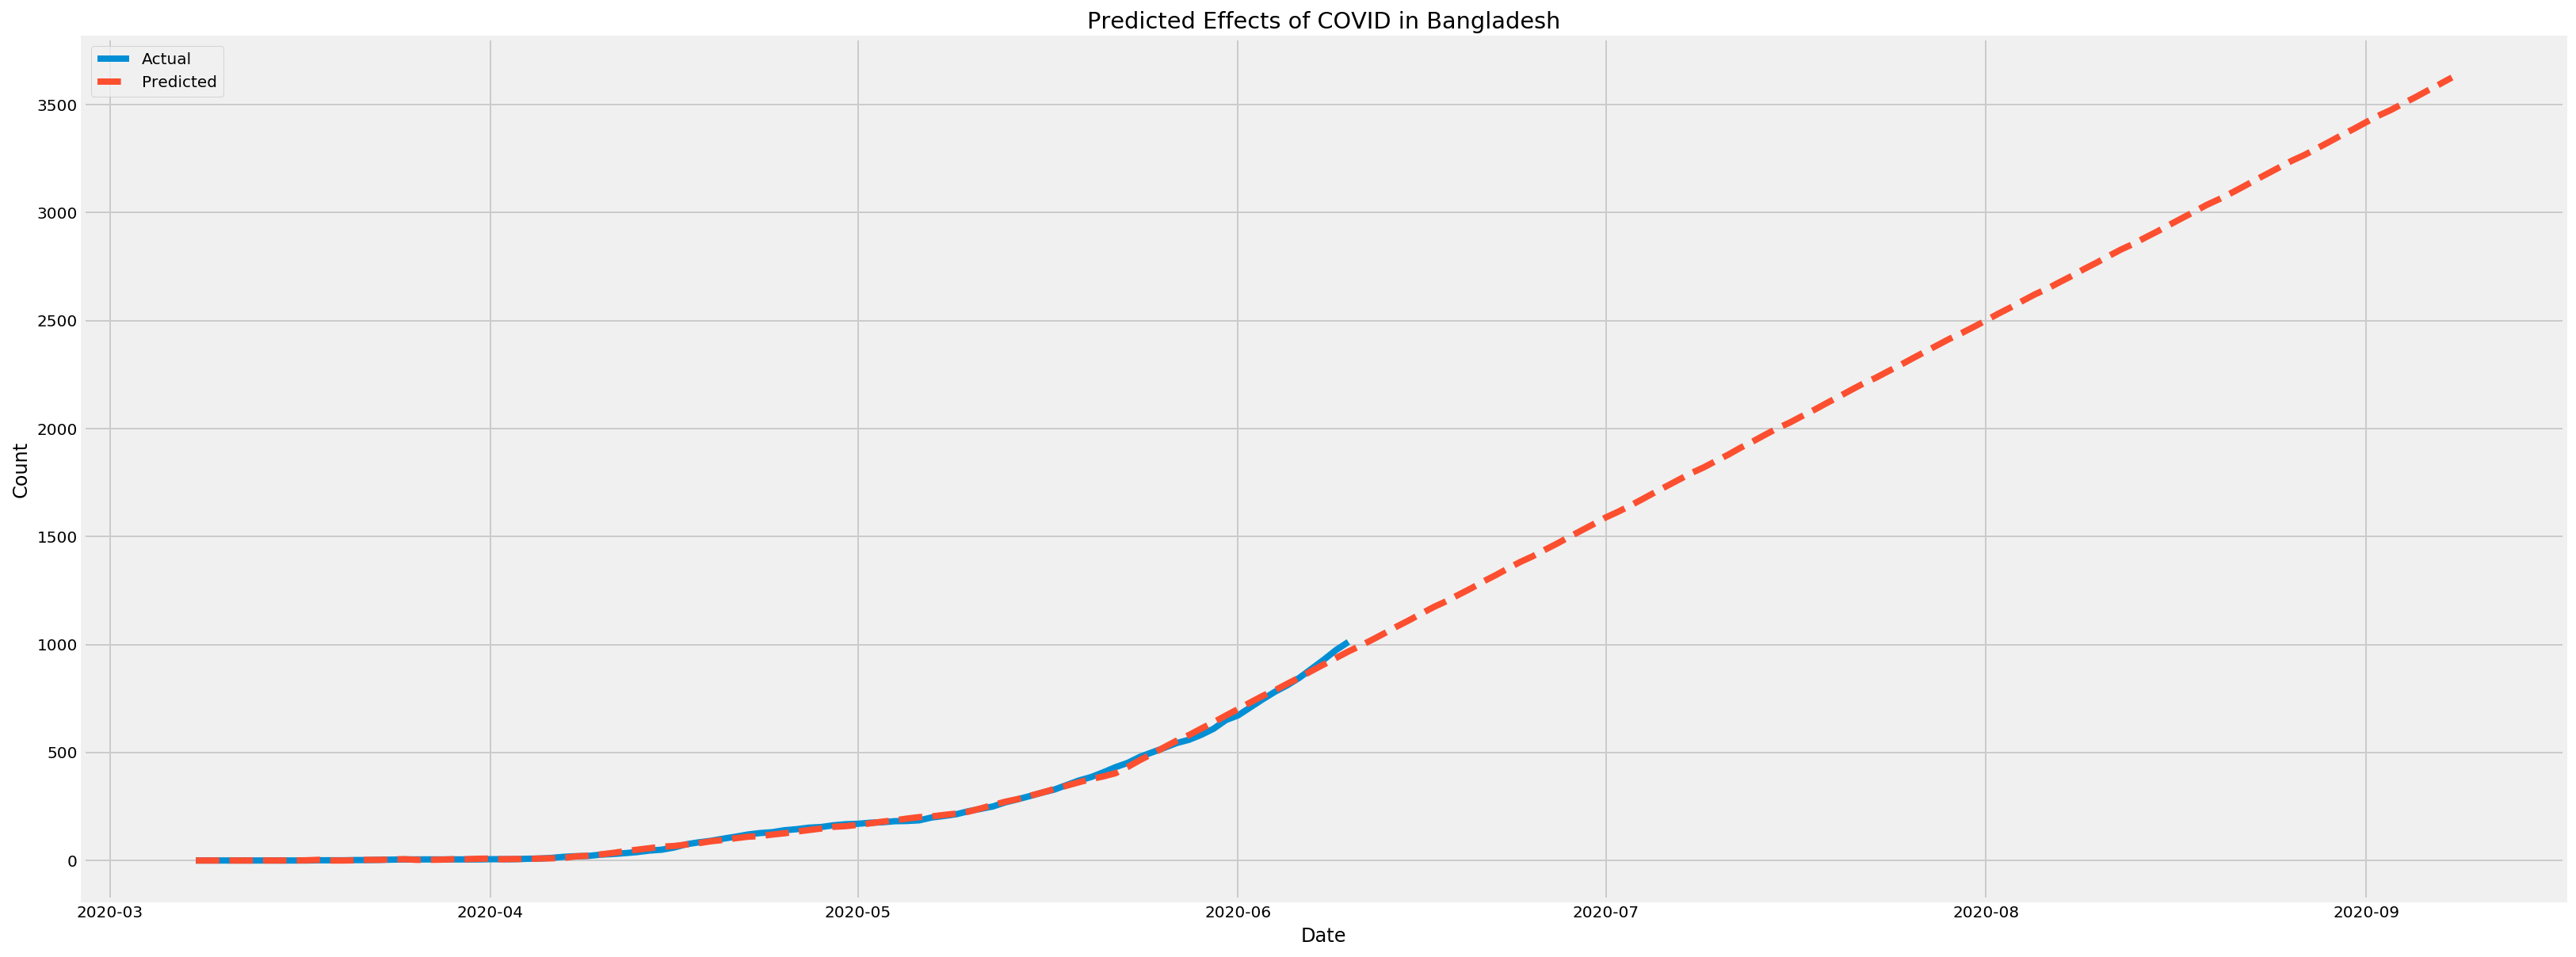

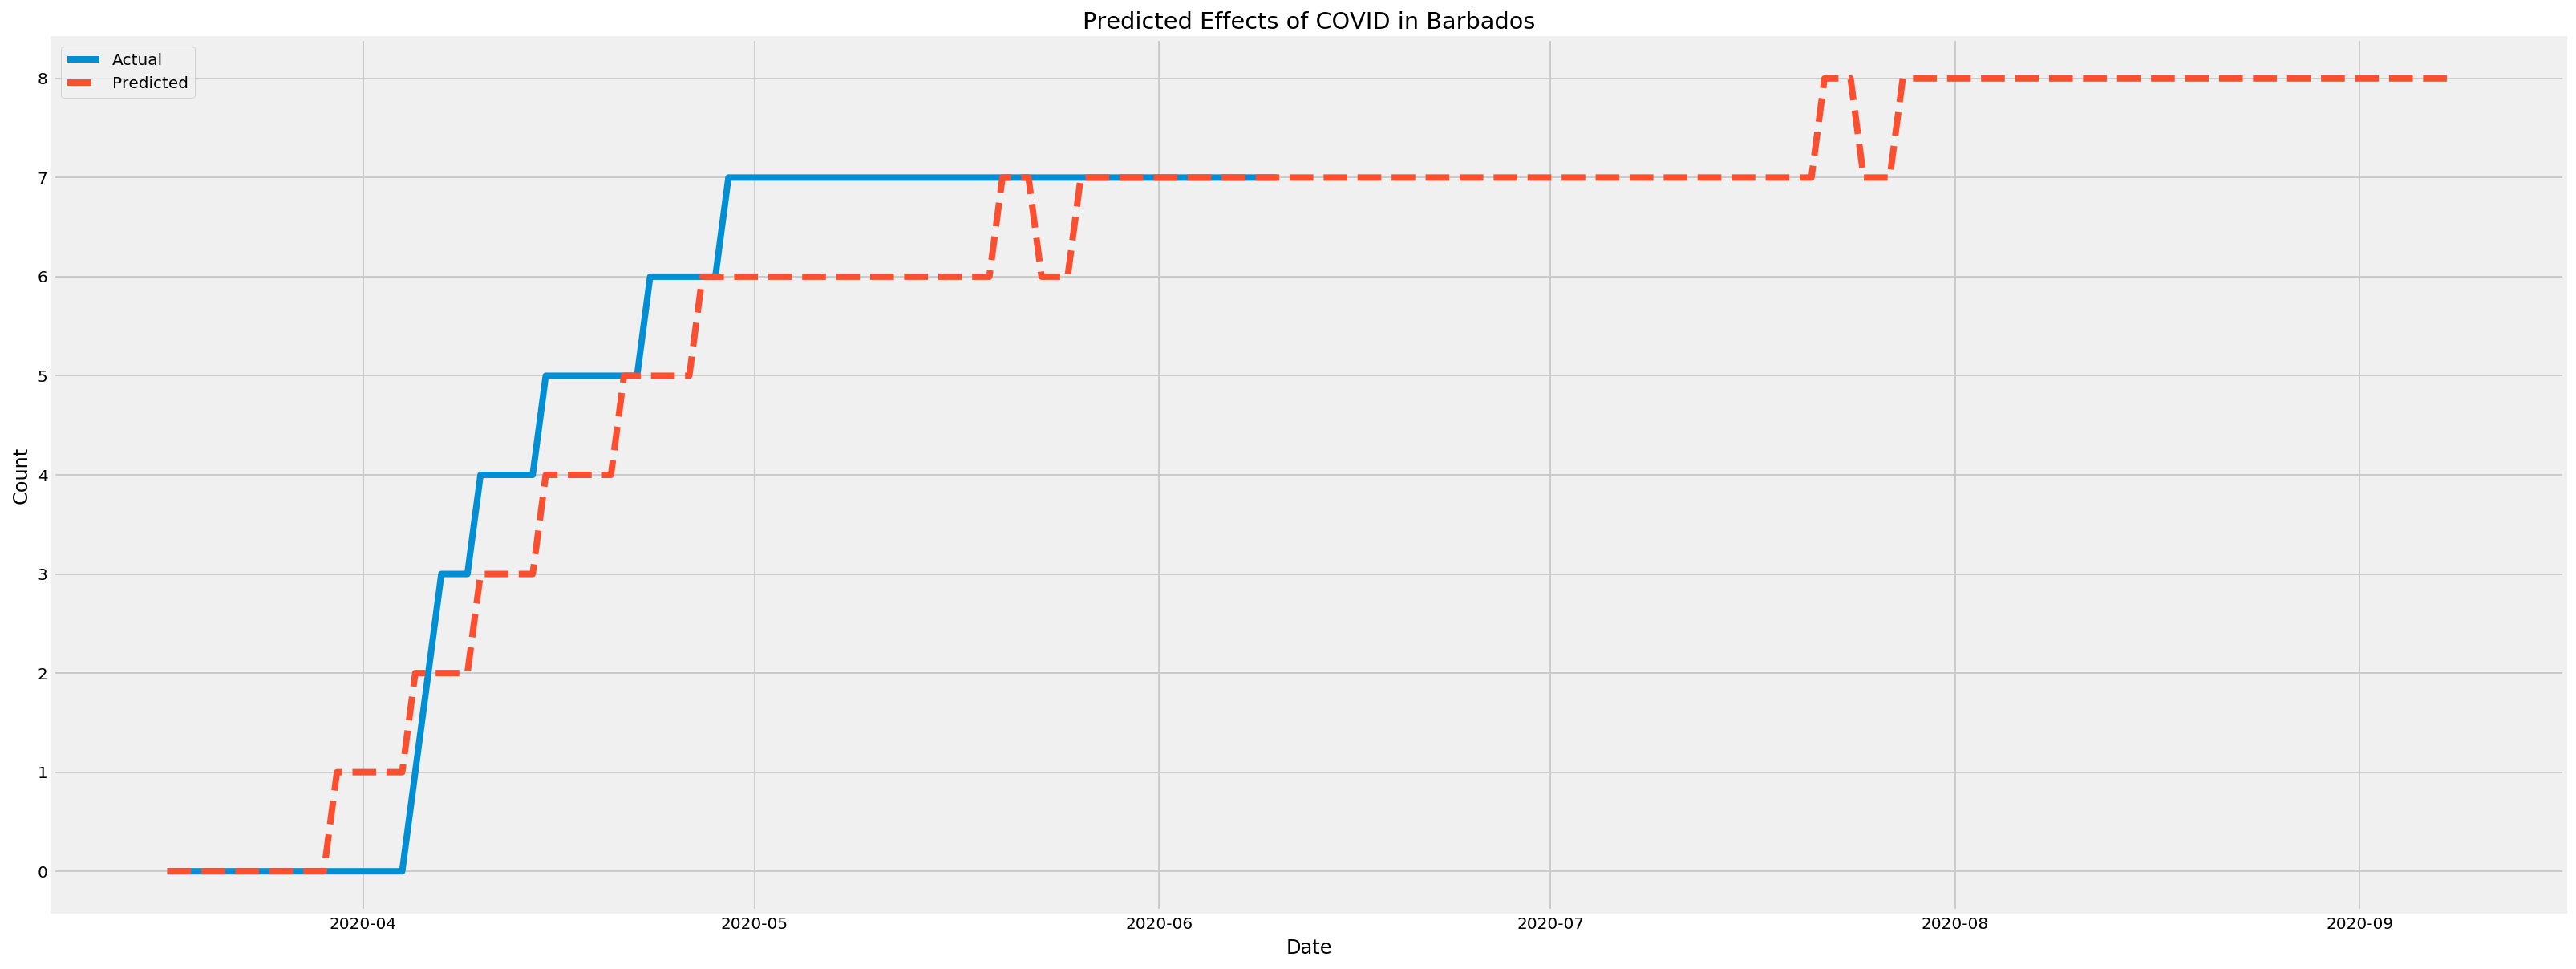

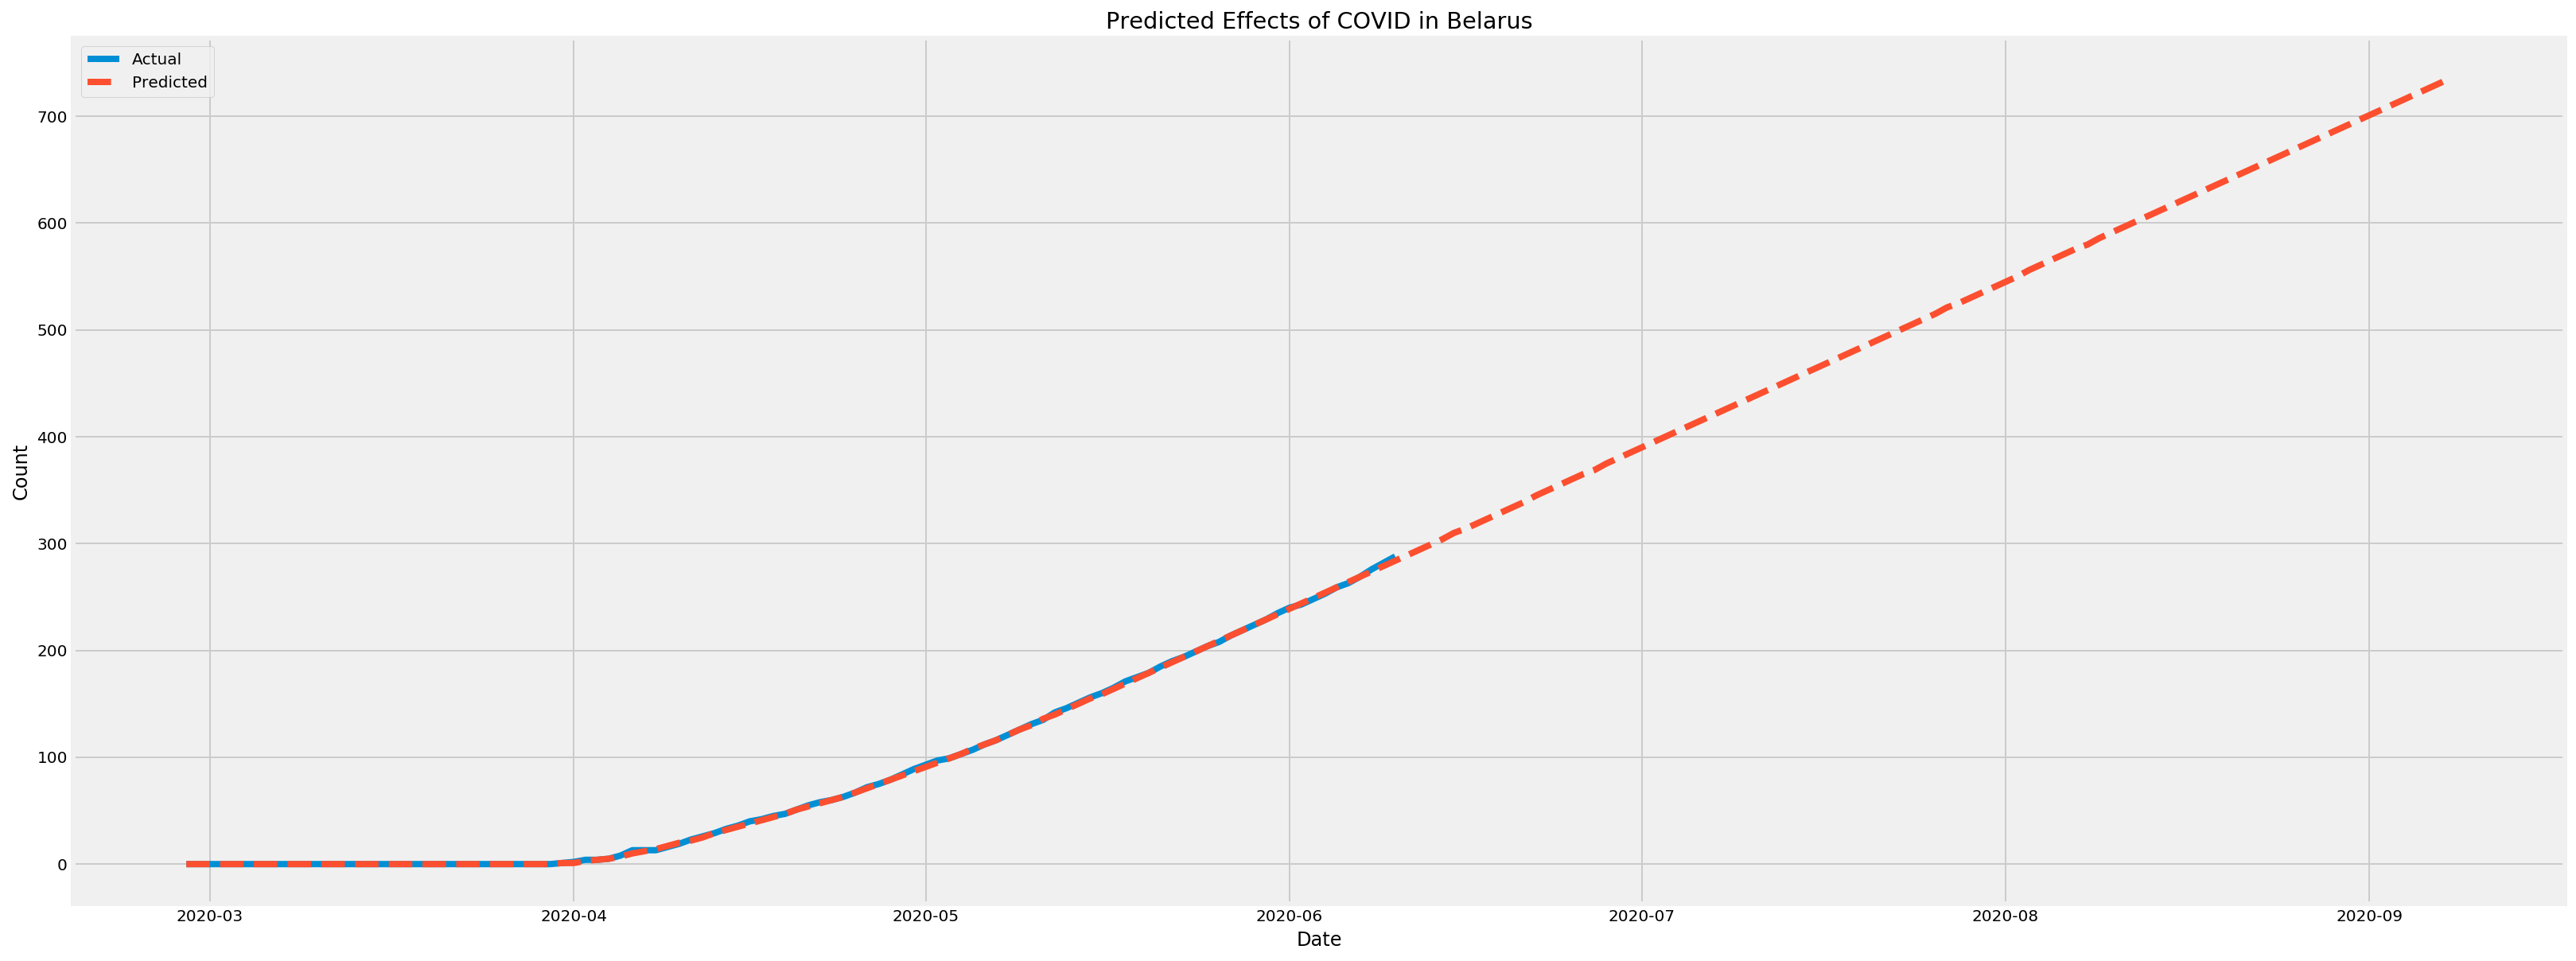

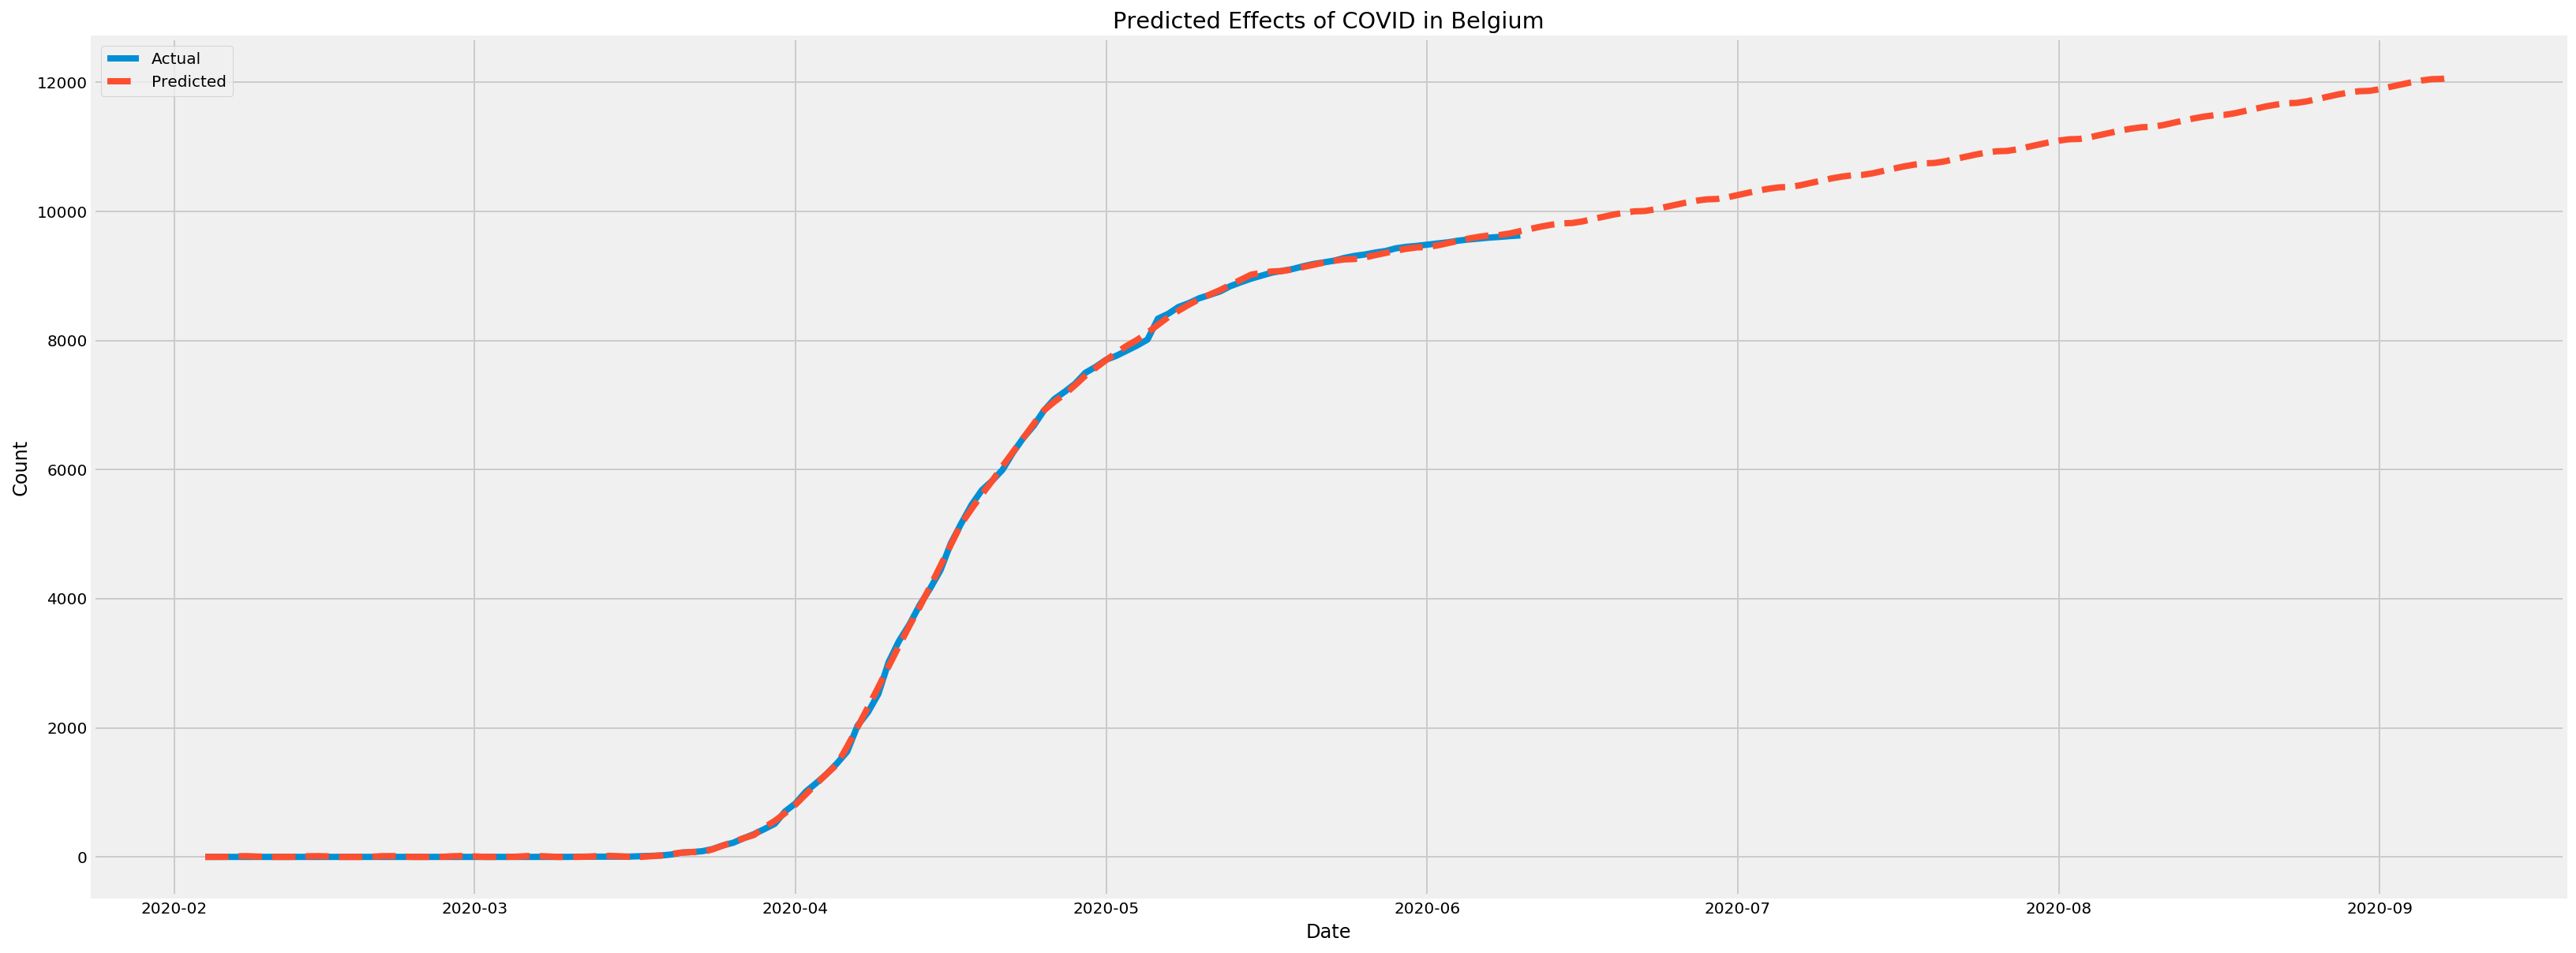

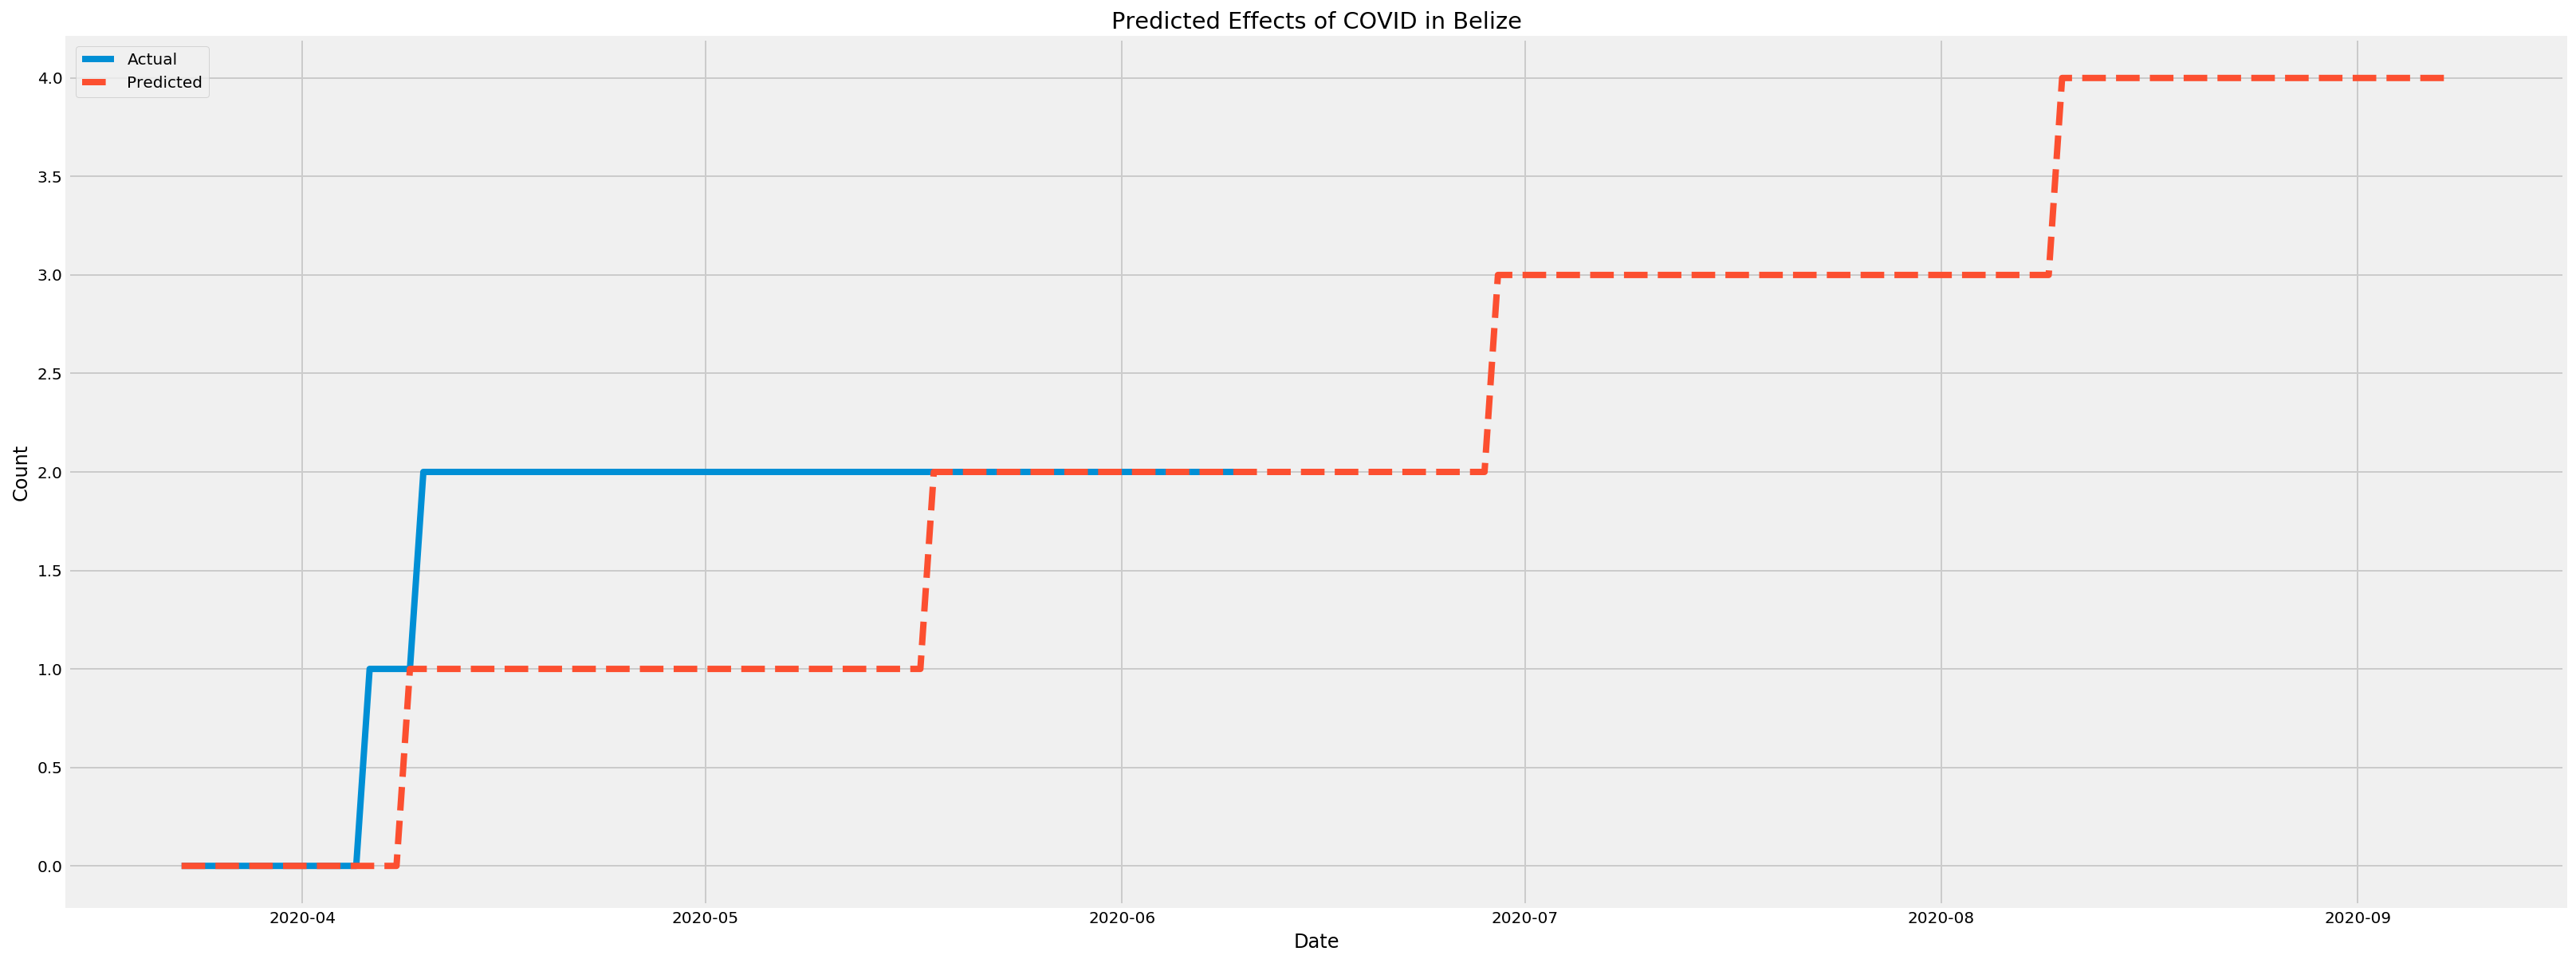

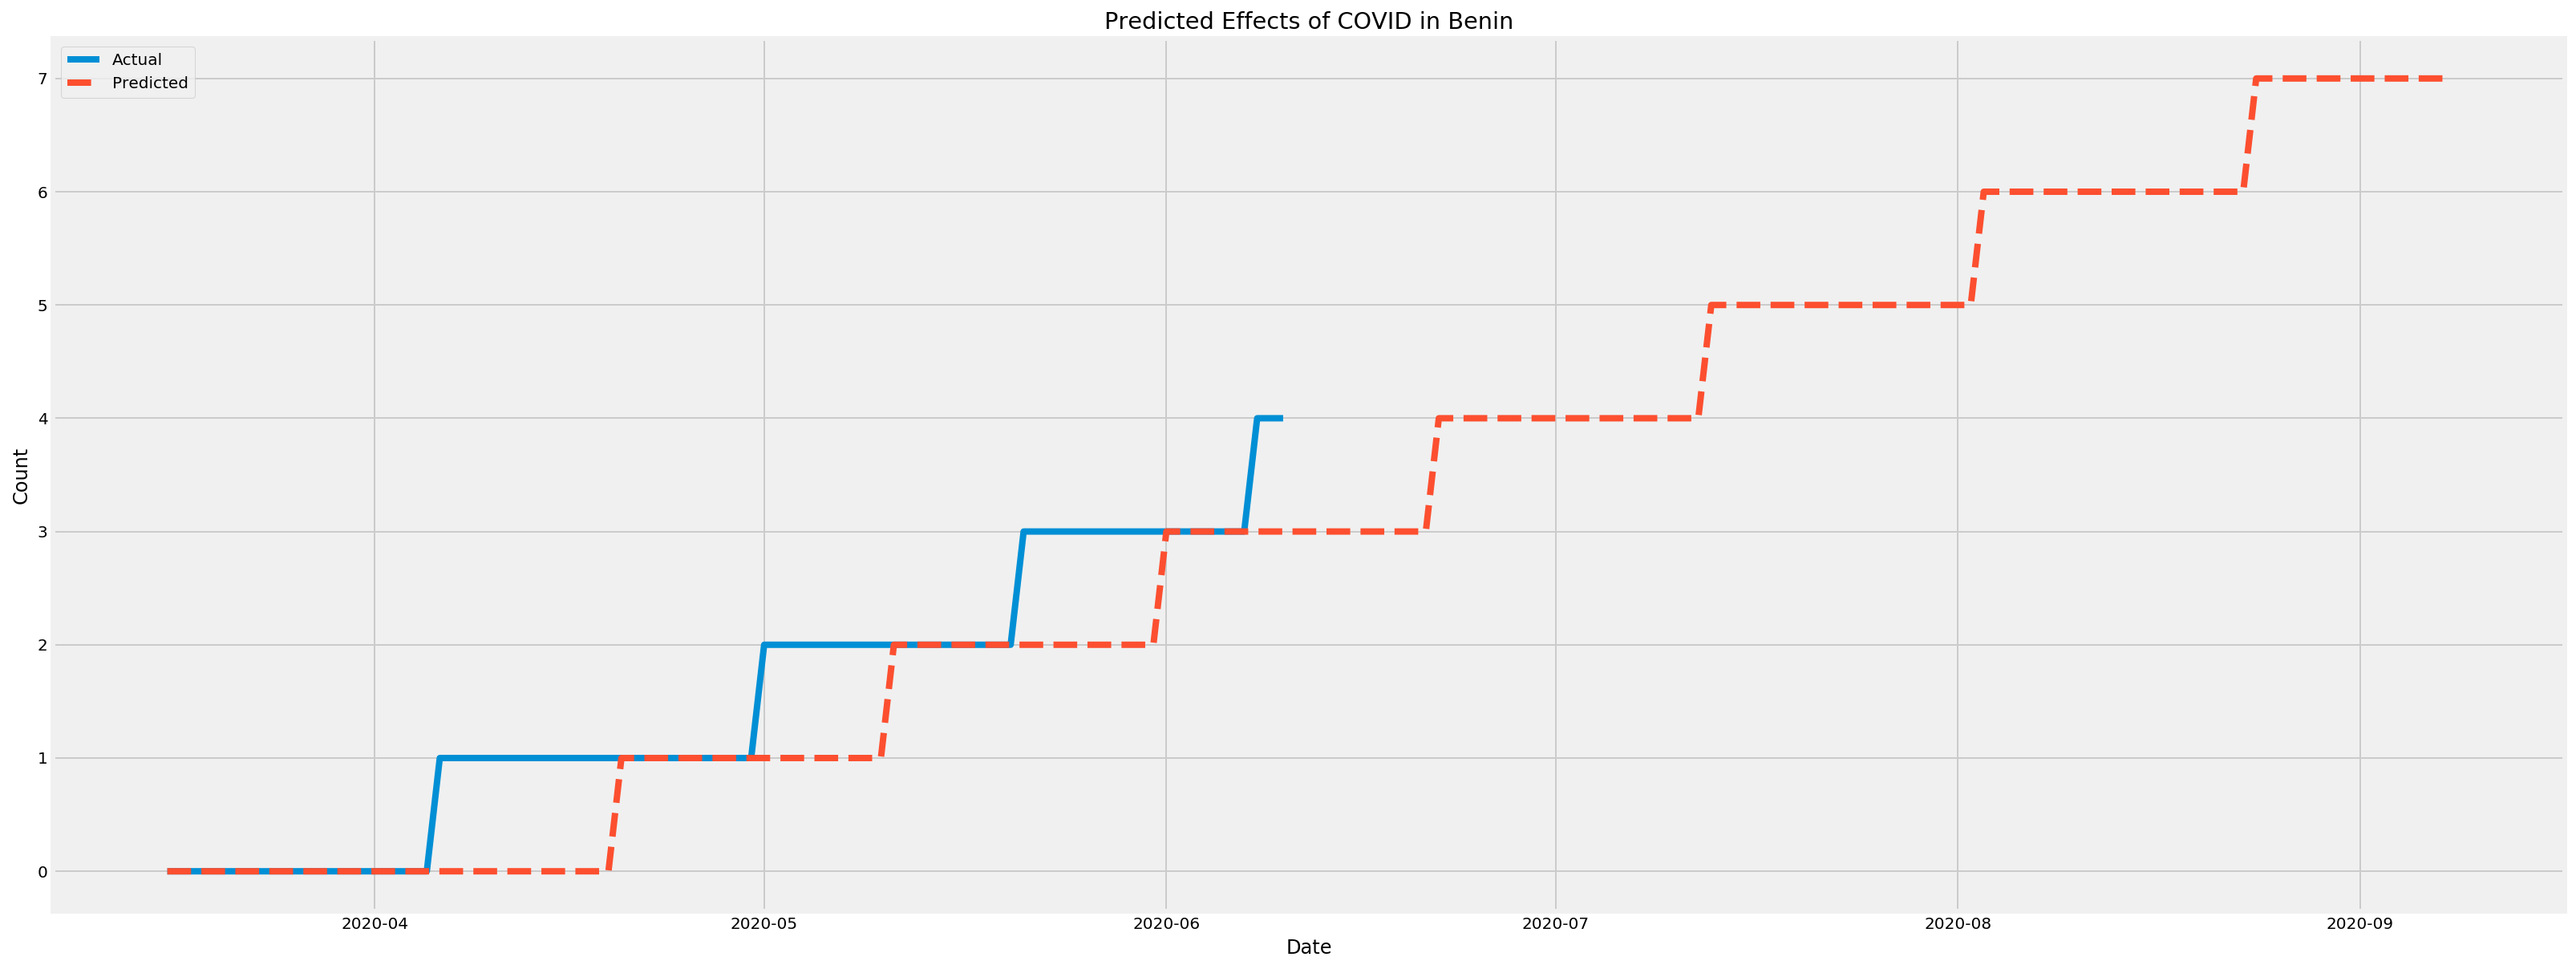

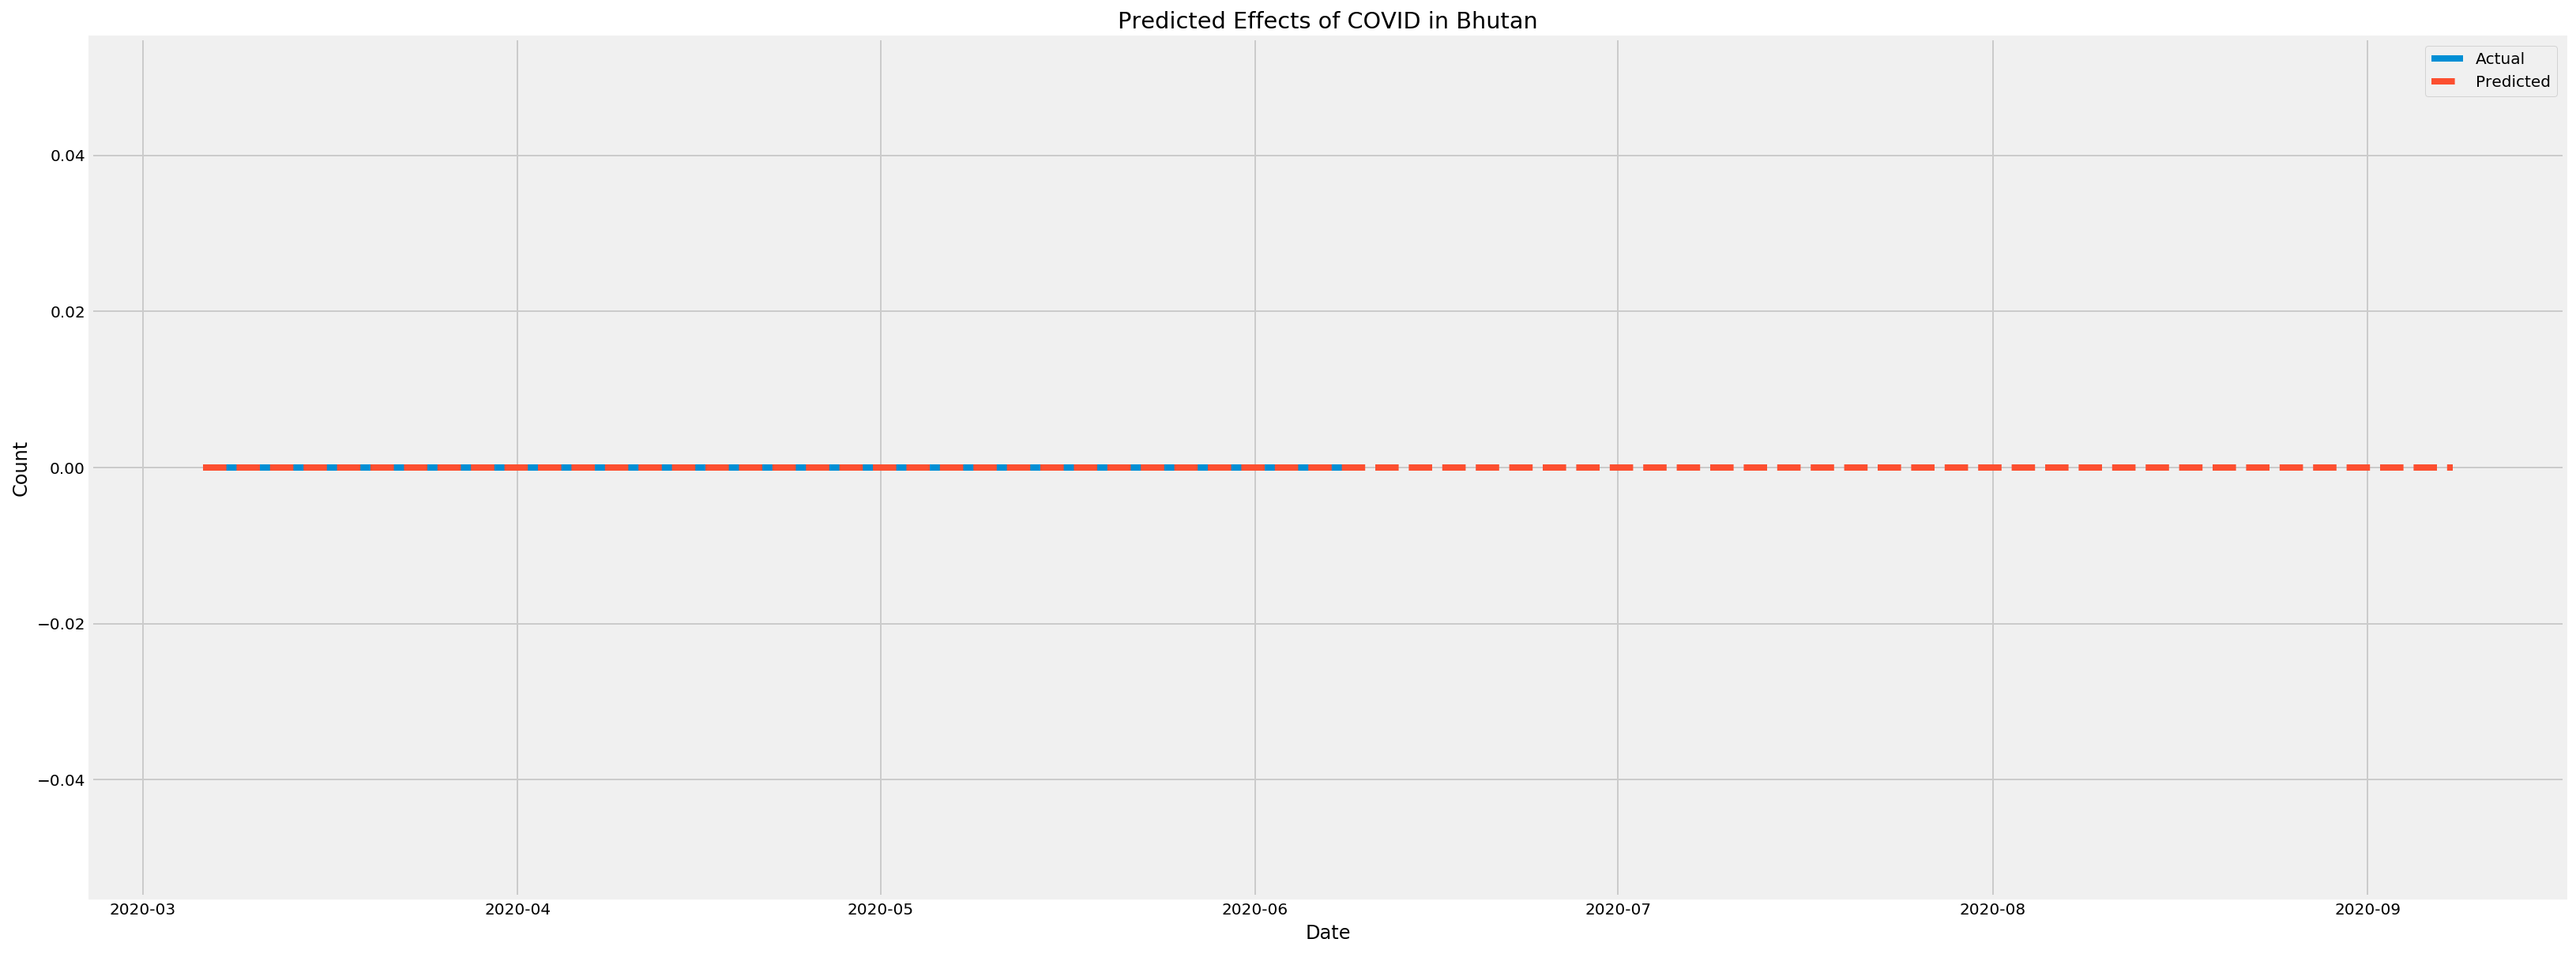

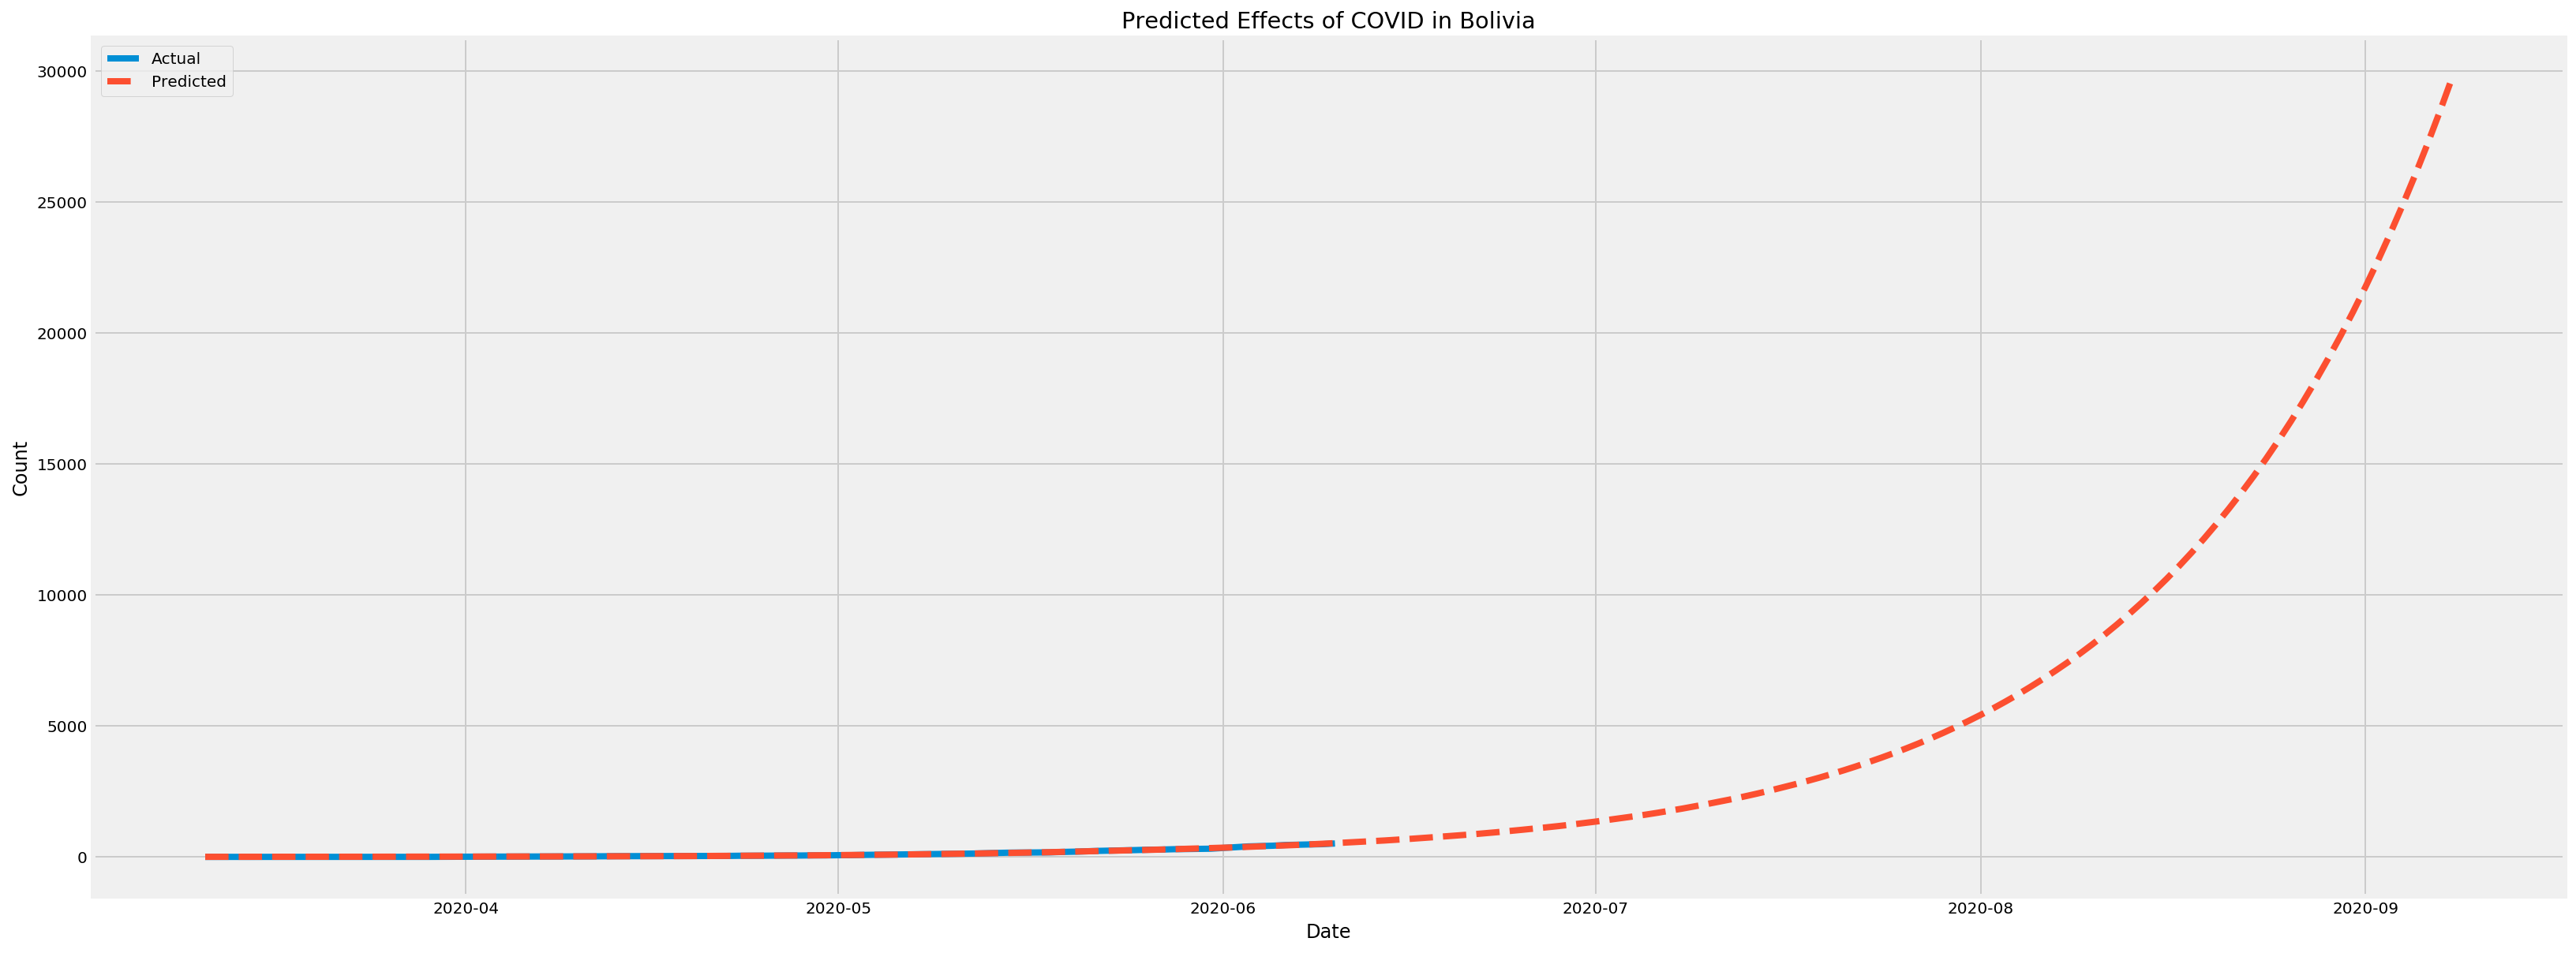

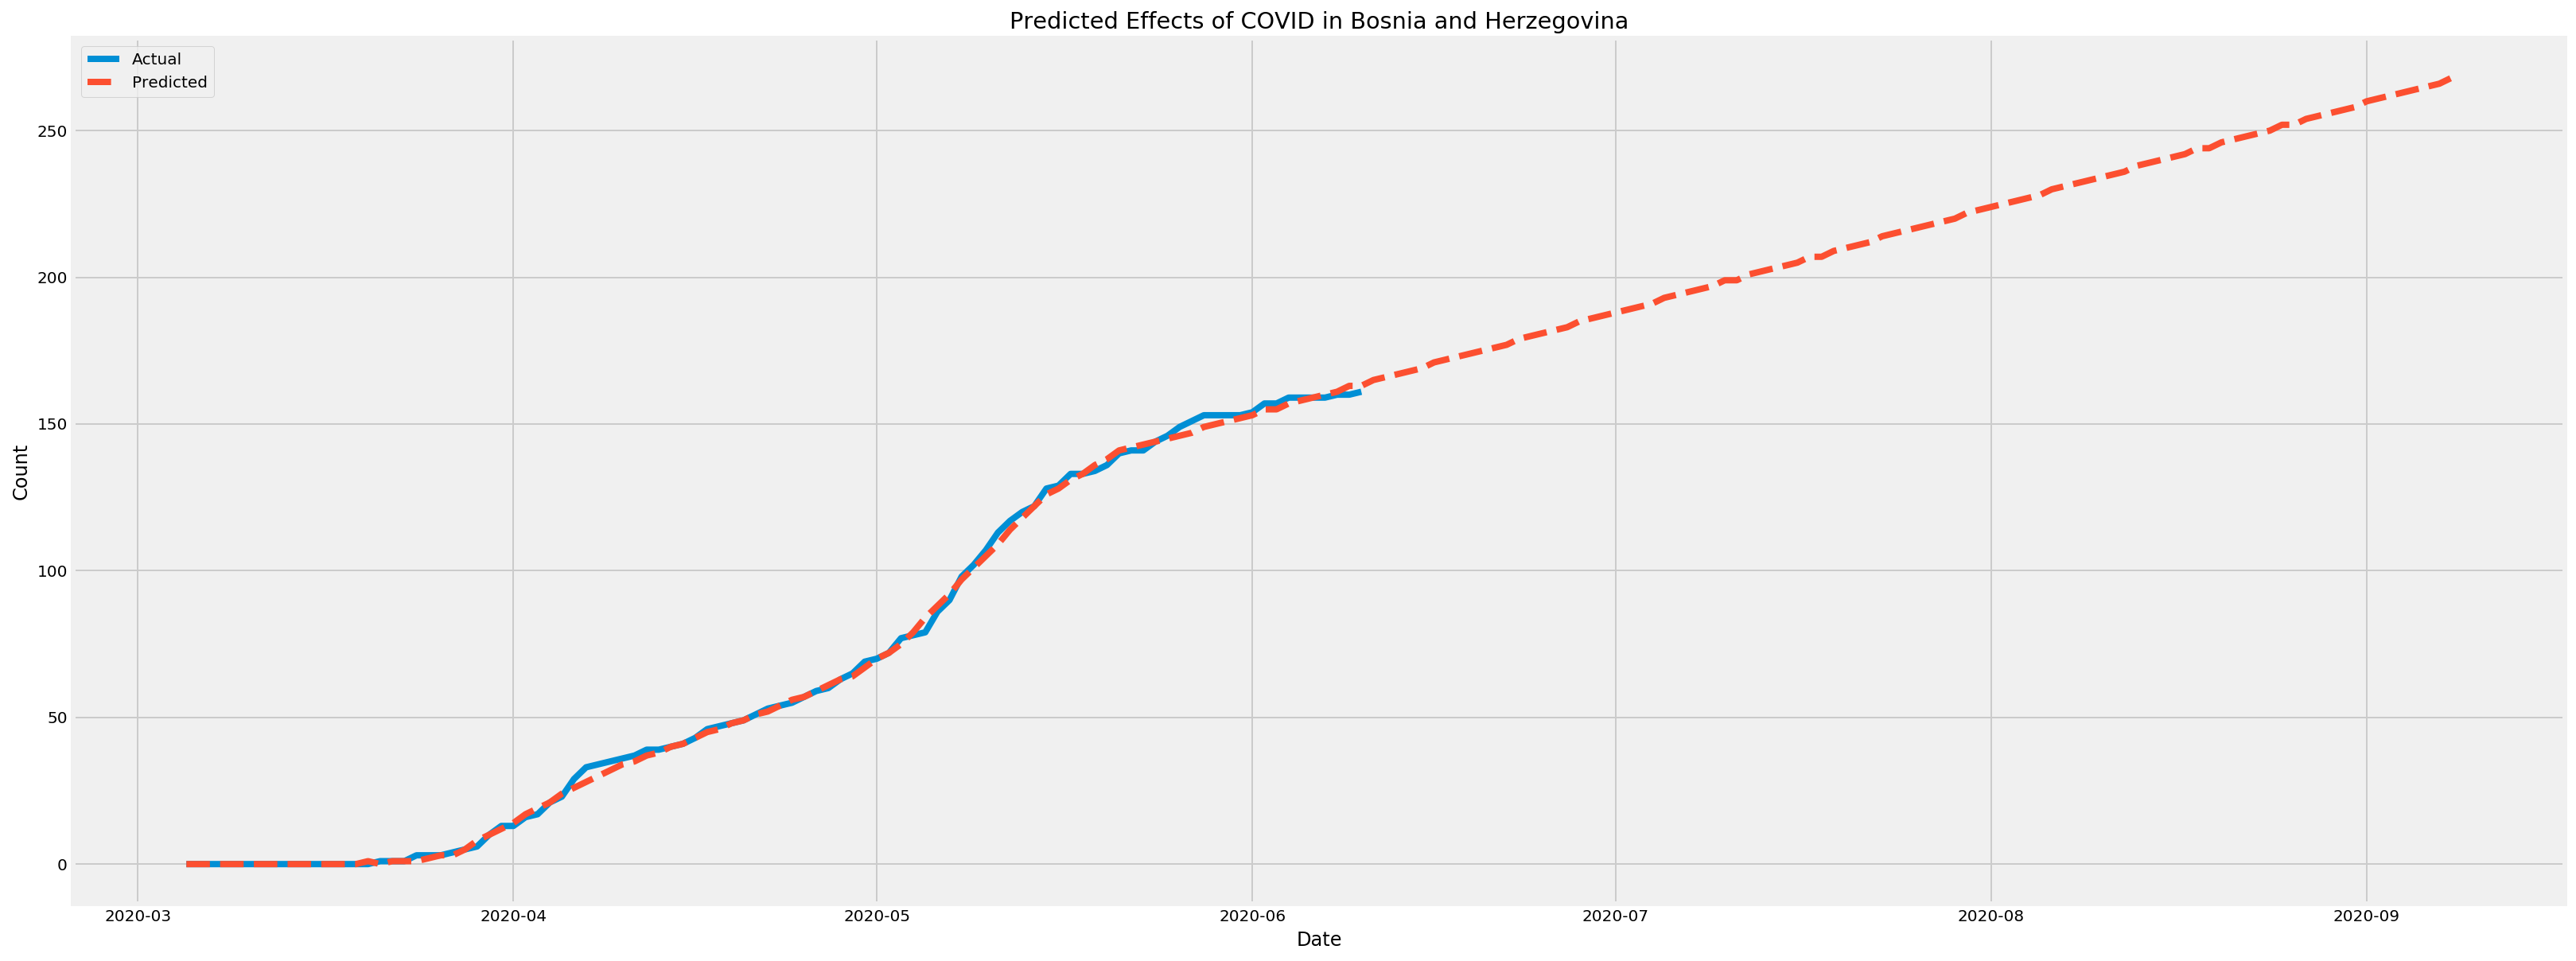

<Figure size 1800x720 with 0 Axes>

In [61]:
%matplotlib inline
%matplotlib inline

for k, v in output.items():
    
    # Inspect
    fig, ax = plt.subplots(figsize = [25, 10])
    ax.plot(v.set_index('ds')['y'], label = 'Actual')
    ax.plot(v.set_index('ds')['yhat'], label = 'Predicted', linestyle = '--')
    ax.legend()
    ax.set_title('Predicted Effects of COVID in {}'.format(k))
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    fig.show();